In [557]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random
import plotly.graph_objects as go
import scipy.stats as stats

In [558]:
# set a global palette for seaborn
sns.set_palette("Accent", desat=1)
sns.set_style("white")

In [559]:
# load data
ego_updates = pd.read_csv('../Clean/ego_updates.csv')
stereo_updates = pd.read_csv('../Clean/stereo_updates.csv')
updates = pd.read_csv('../Clean/updates.csv')
stereo_characteristics_beliefs = pd.read_csv('../Clean/stereo_characteristics_beliefs.csv')


In [560]:
number_participants = len(updates['code'].unique())

# Make new columns

In [561]:
updates['round_misspecification'] = 0
updates.loc[updates['last_button']<updates['type'], 'round_misspecification'] = -1
updates.loc[updates['last_button']>updates['type'], 'round_misspecification'] = 1




# Create a task identifier

In [562]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

# rename some columns

In [563]:
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})

# Identify Subjects who are not learning

In [564]:
# for each player_code, look at the effort in each round starting at round_number 2 and compare it to the previous round
# if the effort is different, then add a value 1 to column 'effort_change'
# if the effort is the same, then add a value 0 to column 'effort_change'

updates['effort_change'] = np.where(updates['round_number']>1, 
                                     updates['effort'] - updates['effort'].shift(1), 
                                     0)

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['effort_change_indicator'] = 0
updates.loc[updates['effort_change']!=0, 'effort_change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['effort_change_sum'] = updates.groupby('player_code')['effort_change_indicator'].transform('sum')

<Axes: xlabel='effort_change_sum', ylabel='Count'>

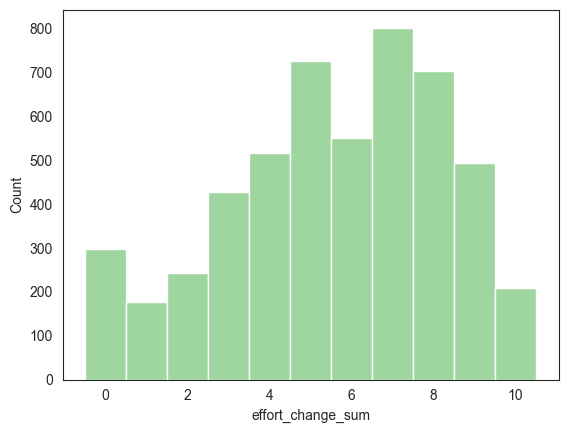

In [565]:
sns.histplot(updates['effort_change_sum'], discrete=True)

In [566]:
len(updates[updates['effort_change_sum']==10])/len(updates['effort_change_sum'])

0.0405982905982906

In [567]:
updates= updates[updates['effort_change_sum']<10]

In [568]:
len(updates['player_code'].unique())/6

74.83333333333333

# Initial beliefs (reported and revealed)

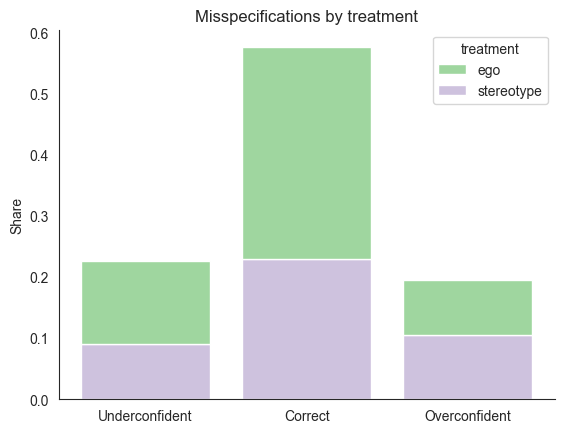

In [569]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')

plt.title('Misspecifications by treatment')

#save figure
plt.savefig('../figures/misspecification_hist.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'round 10')

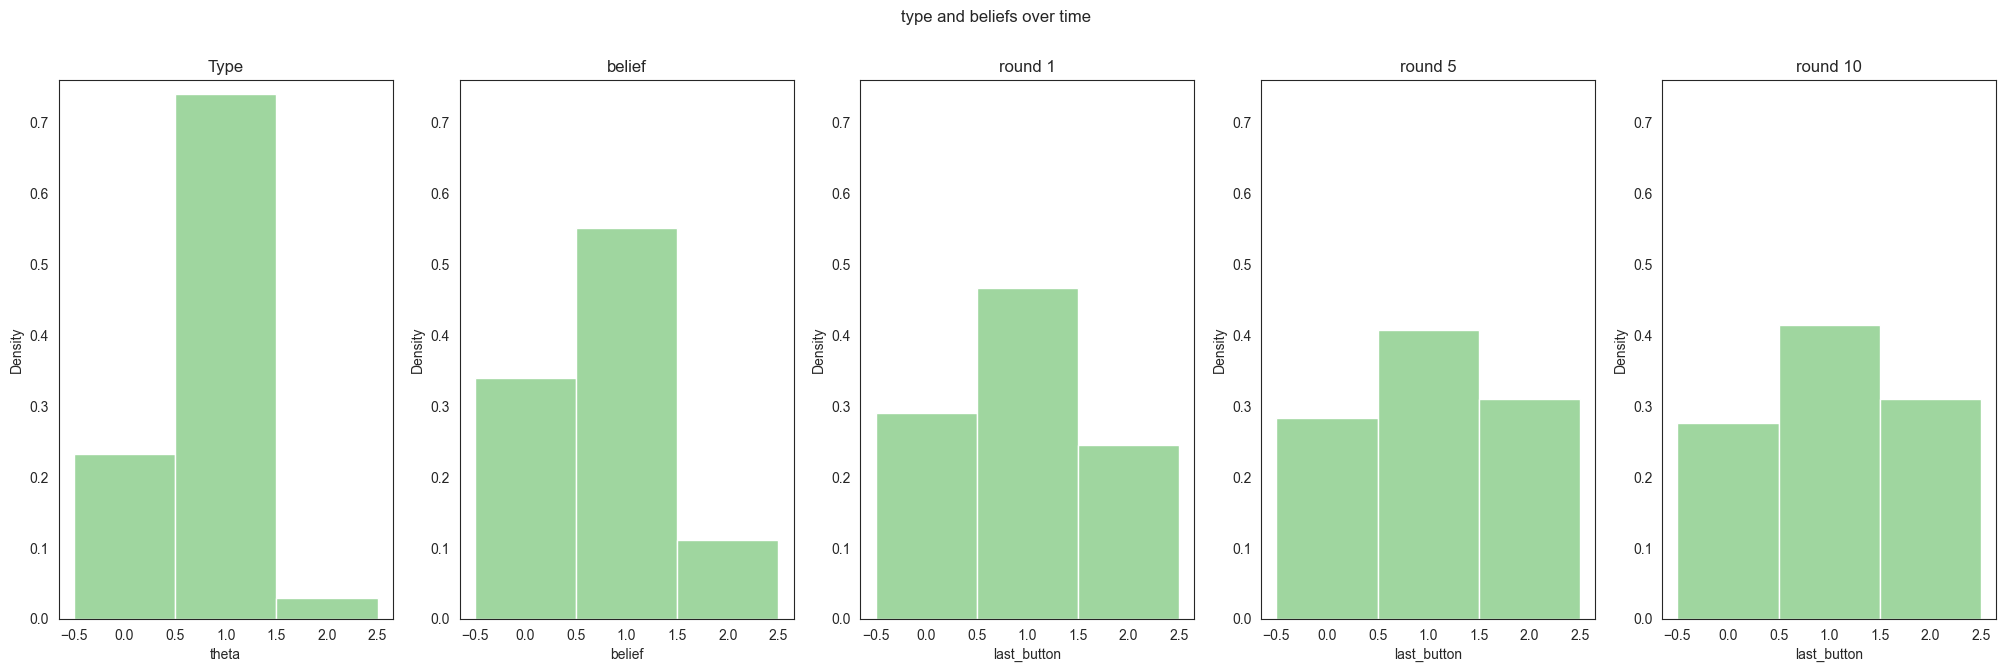

In [570]:
fig, axs = plt.subplots(1, 5, figsize=(25, 7))

fig.suptitle('type and beliefs over time')

sns.histplot(data=updates, x='theta', ax=axs[0], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates, x='belief', ax=axs[1], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==1], x='last_button', ax=axs[2], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==5], x='last_button', ax=axs[3], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==11], x='last_button', ax=axs[4], discrete=True, multiple='dodge', stat='density')

axs[0].set_ylim((0, .76))
axs[1].set_ylim((0, .76))
axs[2].set_ylim((0, .76))
axs[3].set_ylim((0, .76))
axs[4].set_ylim((0, .76))

axs[0].set_title('Type')
axs[1].set_title('belief')
axs[2].set_title('round 1')
axs[3].set_title('round 5')
axs[4].set_title('round 10')


            last_button_consistent
treatment                         
ego                       0.732558
stereotype                0.685864
            last_button_consistent
treatment                         
ego                       0.581395
stereotype                0.450262
            last_button_correct
treatment                      
ego                    0.515504
stereotype             0.413613
            last_button_correct
treatment                      
ego                    0.472868
stereotype             0.397906


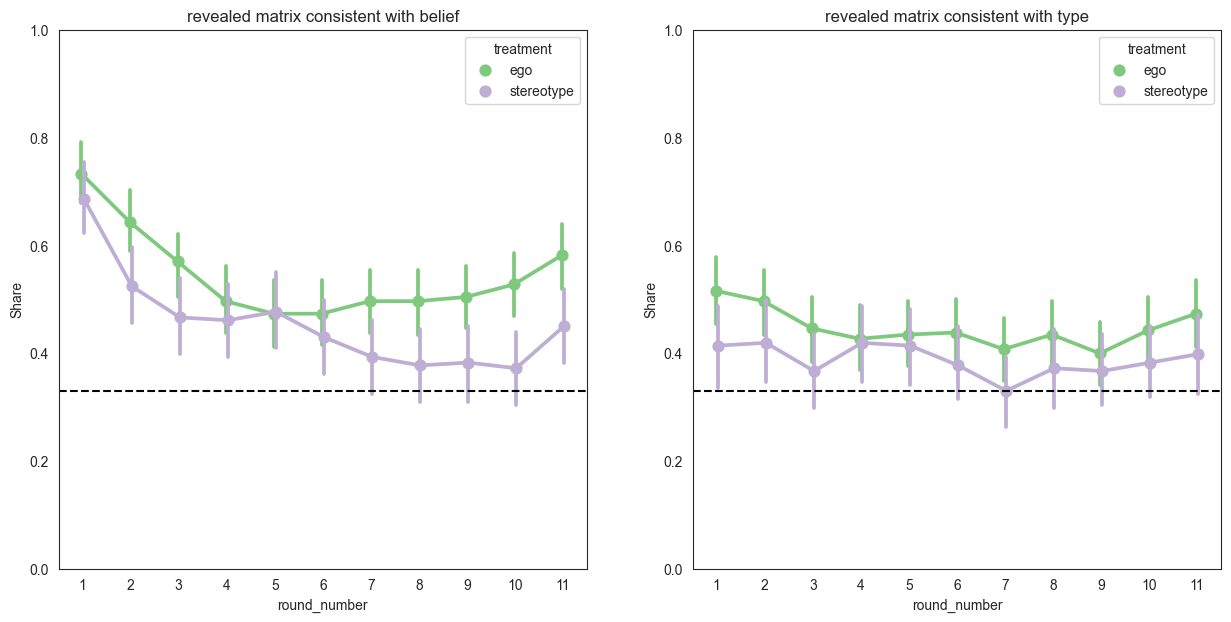

In [571]:
# calculate the share of player_codes for which last_button in round_number 1 is the same as belief
updates['last_button_consistent'] = updates['last_button'] == updates['belief']
updates['last_button_consistent'] = updates['last_button_consistent'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

print(updates.loc[updates['round_number']==11, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

# calculate the share of subjects for whom the last button is the same as their theta
updates['last_button_correct'] = updates['last_button'] == updates['theta']
updates['last_button_correct'] = updates['last_button_correct'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_correct', 'treatment']].groupby('treatment').mean())
print(updates.loc[updates['round_number']==11, ['last_button_correct', 'treatment']].groupby('treatment').mean())


# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', hue='treatment', dodge=True, ax=axs[0])
axs[0].set_ylim((0, 1))
axs[0].set_title('revealed matrix consistent with belief')
axs[0].set_ylabel('Share')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', hue='treatment', dodge=True, ax=axs[1])
axs[1].set_ylim((0, 1))
axs[1].set_title('revealed matrix consistent with type')
axs[1].set_ylabel('Share')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')


(0.0, 1.0)

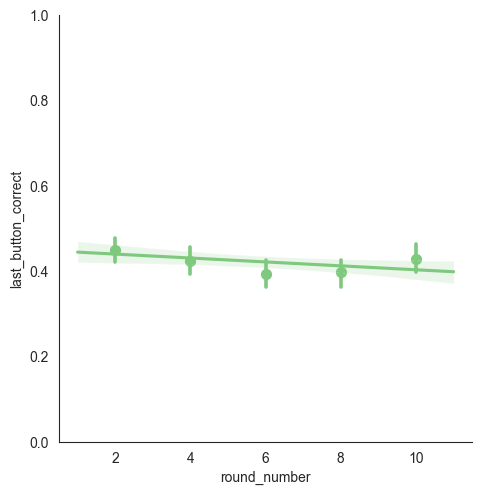

In [572]:
sns.lmplot(data=updates, x='round_number', y='last_button_correct', x_bins=5)
plt.ylim((0, 1))

In [573]:
# regress last_button_correct on round_number in updates
import statsmodels.api as sm
import statsmodels.formula.api as smf

# regress last_button_correct on round_number in updates
model = smf.ols(formula='last_button_correct ~ round_number', data=updates)
results = model.fit()

print(results.summary())



                             OLS Regression Results                            
Dep. Variable:     last_button_correct   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     4.282
Date:                 Wed, 27 Sep 2023   Prob (F-statistic):             0.0386
Time:                         17:08:49   Log-Likelihood:                -3520.3
No. Observations:                 4939   AIC:                             7045.
Df Residuals:                     4937   BIC:                             7058.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4487      0.015    

In [574]:
# create a column in updates called treatment_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)

# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']

# regress last_button on round_number, update_indic and the interaction between the two to see if the slope is different across treatments

import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['last_button']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            last_button   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.542
Date:                Wed, 27 Sep 2023   Prob (F-statistic):             0.0545
Time:                        17:08:49   Log-Likelihood:                -5759.0
No. Observations:                4939   AIC:                         1.153e+04
Df Residuals:                    4935   BIC:                         1.155e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9265      0.031     29.623      0.000       0.865       0.988
round_number        0.0113      0.005      2.453      0.014       0.002       0.020
treatment_indic     0.1072      0.048      2.236      0.025       0.013       0.201
interaction        -0.0134      0.007     -1.889      0.059      -0.027       0.001
==============================================================================
Omnibus:                  1514670.530   Durbin-Watson:                   1.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.757
Skew:                          -0.012   Prob(JB):                     5.11e-81
Kurtosis:                       1.660   Cond. No.                         36.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [575]:
# create a column in updates called treatment_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)

# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']

# regress last_button_correct on round_number, update_indic and the interaction between the two to see if the slope is different across treatments

import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['last_button_correct']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     last_button_correct   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     7.337
Date:                 Wed, 27 Sep 2023   Prob (F-statistic):           6.63e-05
Time:                         17:08:49   Log-Likelihood:                -3511.5
No. Observations:                 4939   AIC:                             7031.
Df Residuals:                     4935   BIC:                             7057.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4782      0.020     24.098      0.000       0.439       0.517
round_number       -0.0053      0.003     -1.807      0.071      -0.011       0.000
treatment_indic    -0.0692      0.030     -2.275      0.023      -0.129      -0.010
interaction         0.0016      0.004      0.361      0.718      -0.007       0.010
==============================================================================
Omnibus:                    18586.498   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              811.072
Skew:                           0.317   Prob(JB):                    7.55e-177
Kurtosis:                       1.119   Cond. No.                         36.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [576]:
# test if the last_button_correct is different across treatments in the last round
stats.ttest_ind(updates.loc[(updates['round_number']==11) & (updates['treatment']=='ego'), 'last_button_correct'],
                updates.loc[(updates['round_number']==11) & (updates['treatment']=='stereotype'), 'last_button_correct'])

Ttest_indResult(statistic=1.582588341288881, pvalue=0.11422256863768032)

# Belief Changes

In [577]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





In [578]:
epsilon_ego = updates.loc[updates['treatment']=='ego', 'change_indicator_sum'].mean()
epsilon_stereo = updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'].mean()

In [579]:
stats.ttest_ind(updates.loc[updates['treatment']=='ego', 'change_indicator_sum'], updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'])

Ttest_indResult(statistic=-11.280628969468271, pvalue=3.709625463988081e-29)

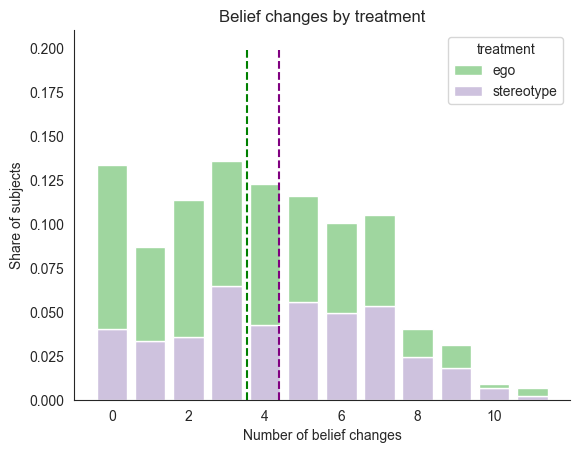

In [580]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

plt.vlines(x=epsilon_ego, ymin=0, ymax=.2, linestyles='--', colors='green', label='ego mean')
plt.vlines(x=epsilon_stereo, ymin=0, ymax=.2, linestyles='--', colors='purple', label='stereo mean')

# Which misspecifications persist the most?
Is there any evidence that people are overconfident?

In [581]:
# make a dataframe with the misspecifiactions in round round 11
# take the last round for each player_code
round_11 = updates.loc[updates['round_number']==11, :]
# check if last_button is above, below or equal to theta and register the misspecification in a column called last_specification_num
round_11.loc[round_11['last_button']>round_11['theta'], 'last_specification_num'] = 1
round_11.loc[round_11['last_button']==round_11['theta'], 'last_specification_num'] = 0
round_11.loc[round_11['last_button']<round_11['theta'], 'last_specification_num'] = -1




/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/637480017.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['last_button']>round_11['theta'], 'last_specification_num'] = 1


In [582]:
#plot the share of subjects that started in each specification and ended in each of them
round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.groupby(['misspecification_num']).count()['code']


misspecification_num  last_specification_num
-1                    -1.0                      0.470588
                       0.0                      0.294118
                       1.0                      0.235294
 0                    -1.0                      0.115830
                       0.0                      0.563707
                       1.0                      0.320463
 1                    -1.0                      0.056818
                       0.0                      0.250000
                       1.0                      0.693182
Name: code, dtype: float64

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/3885935428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['last_specification_num']==-1, 'last_specification'] = 'under'


(0.0, 1.0)

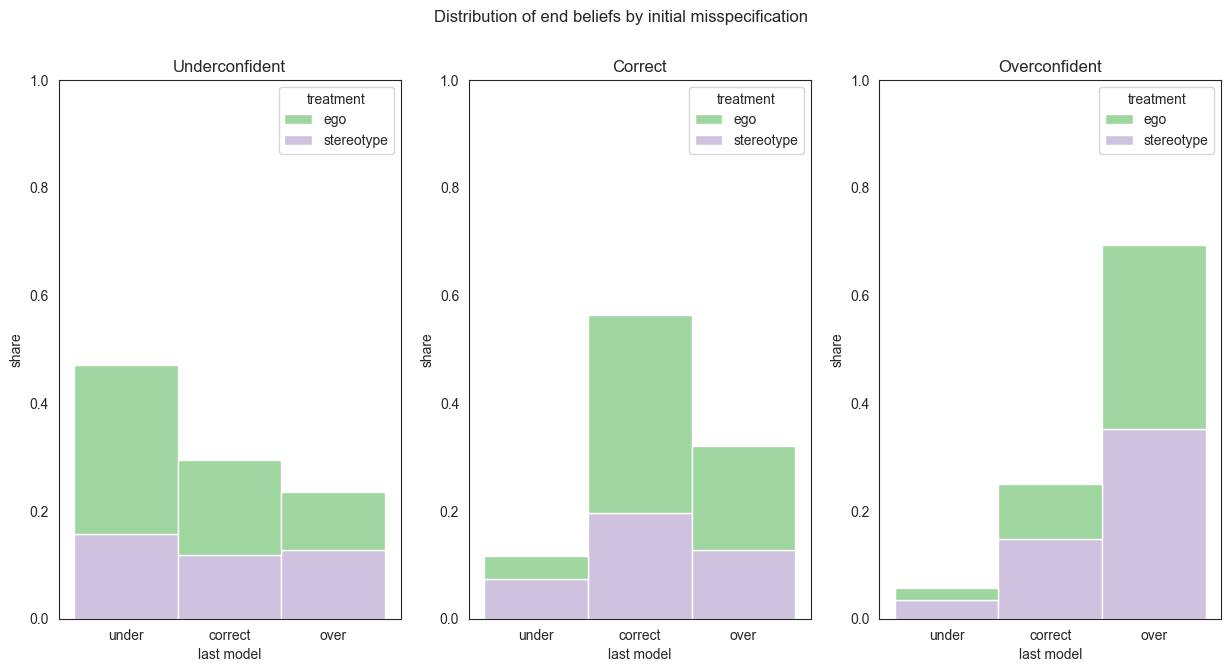

In [583]:
# for the data frame round_11, create a column called last_specification_num that is -1 if the last_specification is under, 0 if it is correct and 1 if it is over
round_11.loc[round_11['last_specification_num']==-1, 'last_specification'] = 'under'
round_11.loc[round_11['last_specification_num']==0, 'last_specification'] = 'correct'
round_11.loc[round_11['last_specification_num']==1, 'last_specification'] = 'over'

# plot 3 histograms side by side for each initial misspecification
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Distribution of end beliefs by initial misspecification')
# the first histogram is for those who began underconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='under'], x='last_specification_num',  ax=axs[0], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0].set_title('Underconfident')
axs[0].set_ylabel('share')
axs[0].set_xlabel('last model')
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim((0, 1))


# the second histogram is for those who began correct, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='correct'], x='last_specification_num', ax=axs[1], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1].set_title('Correct')
axs[1].set_ylabel('share')
axs[1].set_xlabel('last model')
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim((0, 1))

# the third histogram is for those who began overconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='over'], x='last_specification_num', ax=axs[2], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[2].set_title('Overconfident')
axs[2].set_ylabel('share')
axs[2].set_xlabel('last model')
axs[2].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[2].set_ylim((0, 1))


In [584]:
round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.count()['code']

misspecification_num  last_specification_num
-1                    -1.0                      0.106904
                       0.0                      0.066815
                       1.0                      0.053452
 0                    -1.0                      0.066815
                       0.0                      0.325167
                       1.0                      0.184855
 1                    -1.0                      0.011136
                       0.0                      0.048998
                       1.0                      0.135857
Name: code, dtype: float64

Text(0.5, 23.52222222222222, 'Final misspecification')

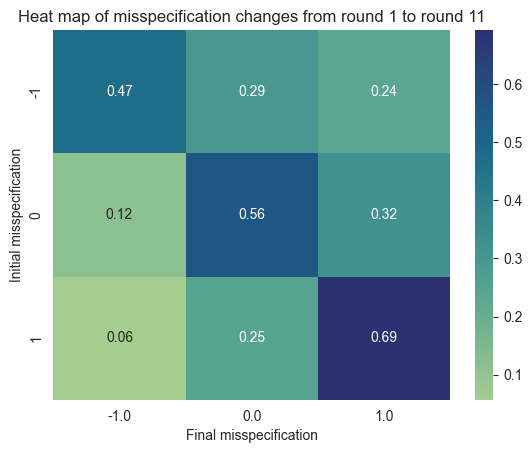

In [612]:
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of misspecification changes from round 1 to round 11')
plt.ylabel('Initial misspecification')
plt.xlabel('Final misspecification')


Text(0.5, 23.52222222222222, 'Final misspecification')

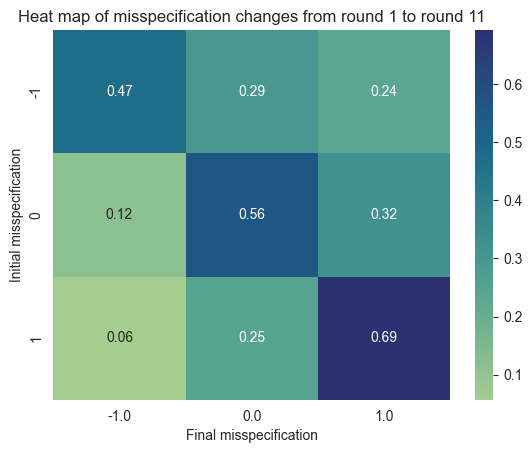

In [586]:
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of misspecification changes from round 1 to round 11')
plt.ylabel('Initial misspecification')
plt.xlabel('Final misspecification')

Text(0.5, 1.0, 'omega = 2')

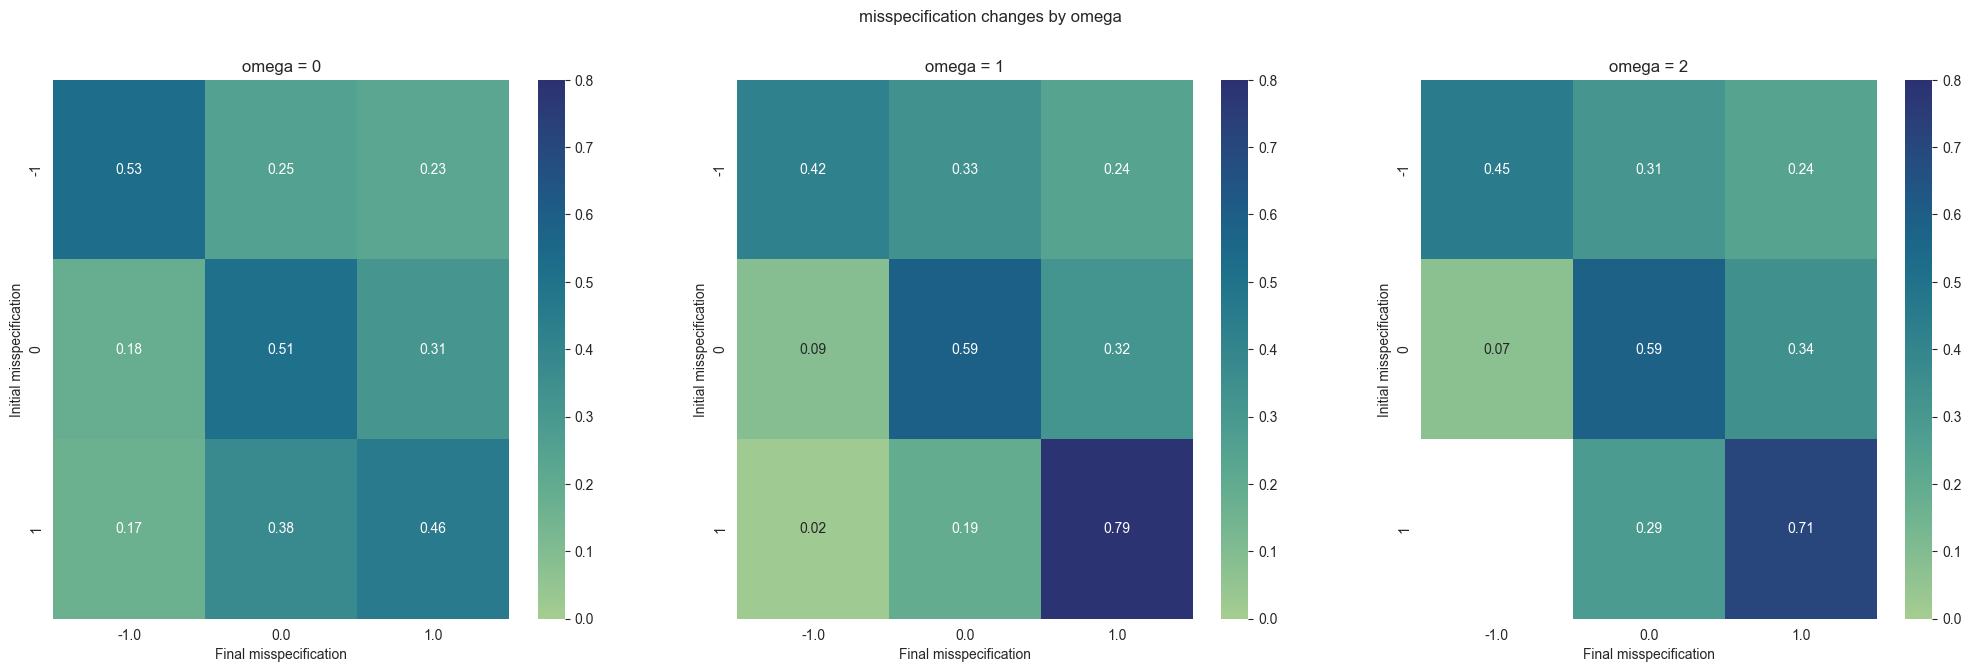

In [587]:
# do 3 heatmaps of the share of observations with each misspecification and each misspecification in round 11. one plot for each omega
# for omega = 0
fig, axs = plt.subplots(1, 3, figsize=(25, 7))
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==0].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==0)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[0], vmax=.8, vmin=0)
plt.suptitle('misspecification changes by omega')
axs[0].set_ylabel('Initial misspecification')
axs[0].set_xlabel('Final misspecification')
axs[0].set_title('omega = 0')

# for omega = 1
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==1].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==1)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[1], vmax=.8, vmin=0)
axs[1].set_ylabel('Initial misspecification')
axs[1].set_xlabel('Final misspecification')
axs[1].set_title('omega = 1')

# for omega = 2
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==2].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==2)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[2], vmax=.8, vmin=0)
axs[2].set_ylabel('Initial misspecification')
axs[2].set_xlabel('Final misspecification')
axs[2].set_title('omega = 2')


Text(0.5, 1.0, 'theta = 2')

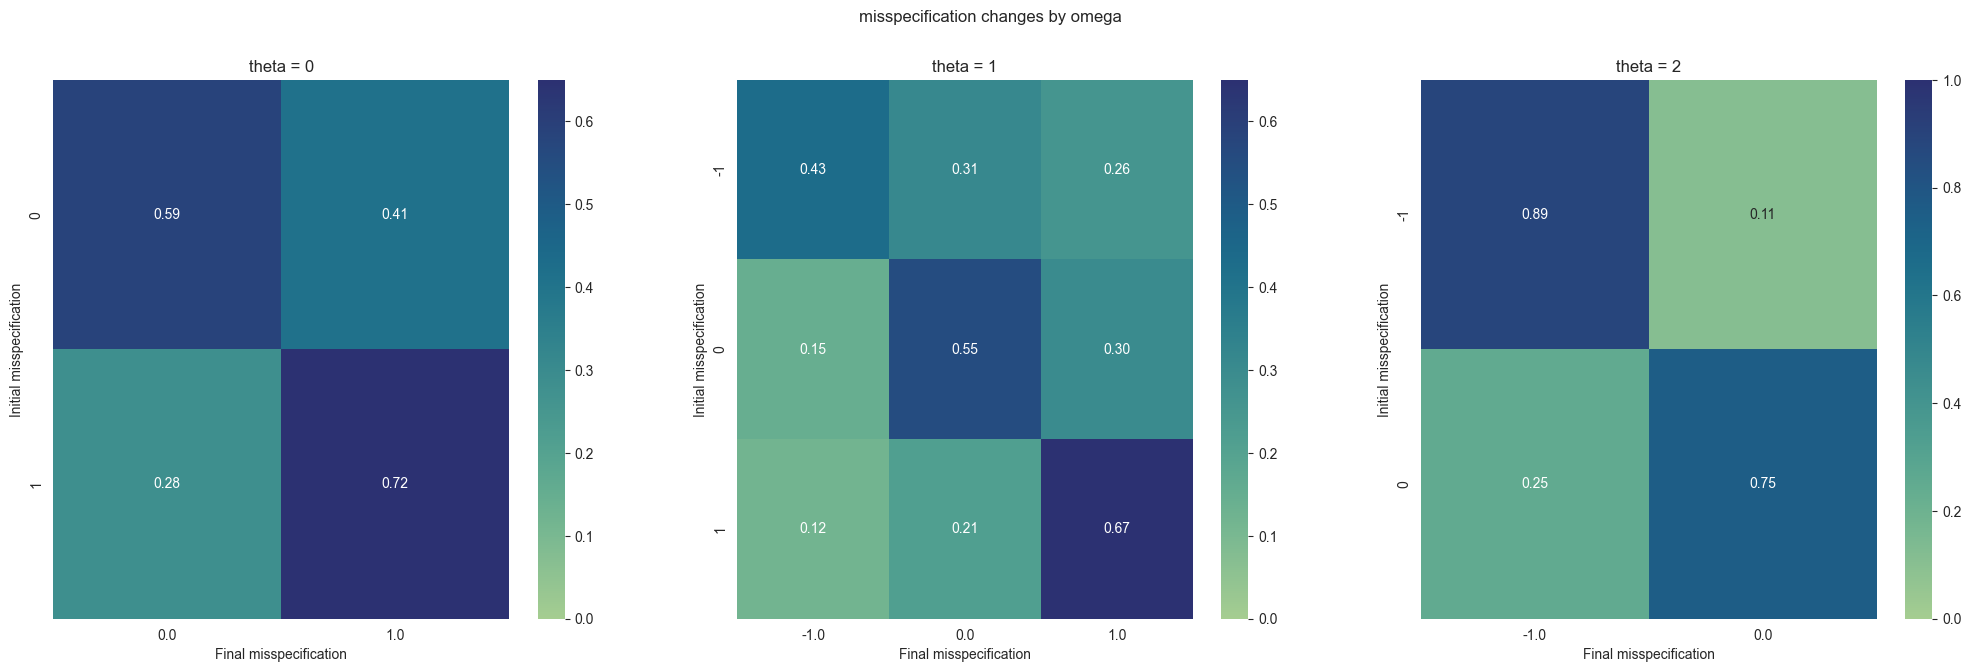

In [588]:
# do 3 heatmaps of the share of observations with each misspecification and each misspecification in round 11. one plot for each theta
# for theta = 0
fig, axs = plt.subplots(1, 3, figsize=(25, 7))
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==0].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==0)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[0], vmax=.65, vmin=0)
plt.suptitle('misspecification changes by omega')
axs[0].set_ylabel('Initial misspecification')
axs[0].set_xlabel('Final misspecification')
axs[0].set_title('theta = 0')

# for theta = 1
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==1].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==1)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[1], vmax=.65, vmin=0)
axs[1].set_ylabel('Initial misspecification')
axs[1].set_xlabel('Final misspecification')
axs[1].set_title('theta = 1')

# for theta = 2
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==2].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==2)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='crest', fmt='.2f', ax=axs[2], vmax=1, vmin=0)
axs[2].set_ylabel('Initial misspecification')
axs[2].set_xlabel('Final misspecification')
axs[2].set_title('theta = 2')

# Choices one step ahead

Text(0.5, 1.0, 'Heat map of effort changes one round ahead')

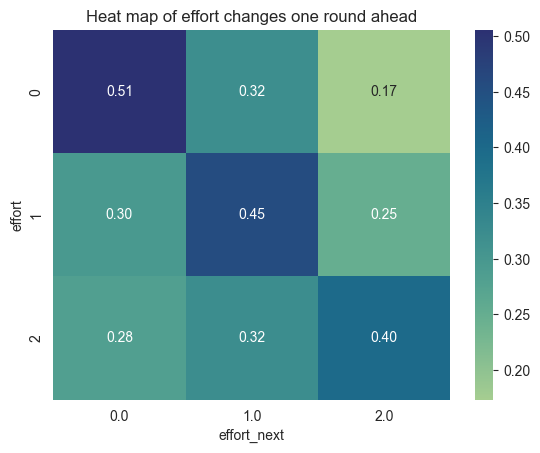

In [589]:
# plot a heat map of the share of subjects that chose each of the effort_next after each value of effort

# in the data frame updates, create a column called effort_next which is the effort chosen in the next round_number
updates['effort_next'] = updates['effort'].shift(-1)

# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead')


## do people settle down in a choice

## are choices one step ahead different by omega

Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 0')

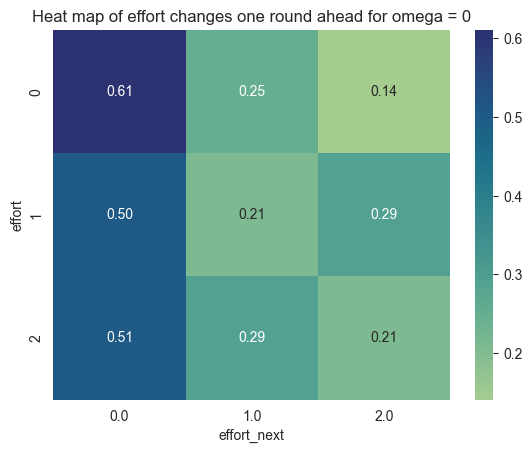

In [590]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==0)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==0)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 0')




Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 1')

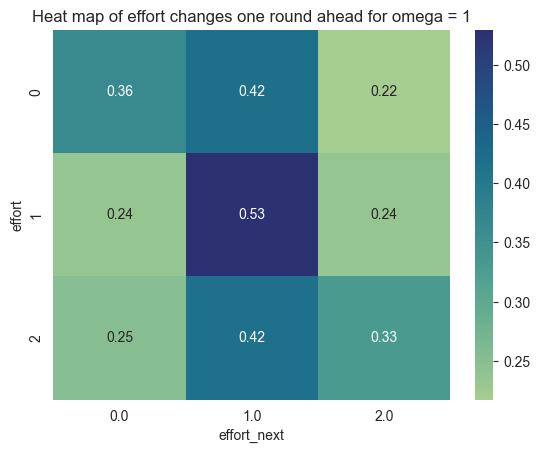

In [591]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==1)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==1)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 1')

Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 2')

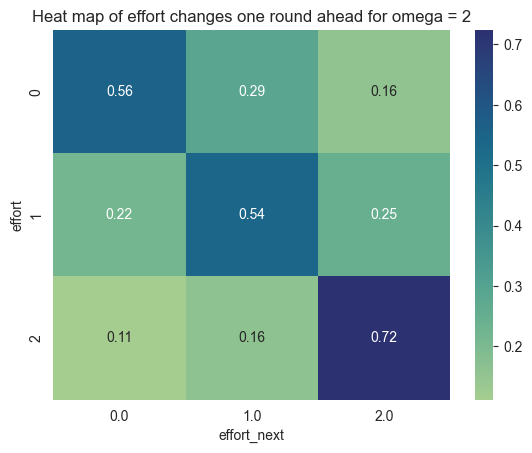

In [592]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==2)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==2)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 2')

# Stereotypes

In [594]:
stereo_characteristics_beliefs.columns

Index(['belief_self', 'certainty_self', 'topic', 'gender_other',
       'nationality_other', 'code', 'belief', 'certainty', 'gender',
       'nationality', 'belief_other', 'certainty_other', 'misspecification',
       'round_number'],
      dtype='object')

<Axes: xlabel='misspecification', ylabel='Probability'>

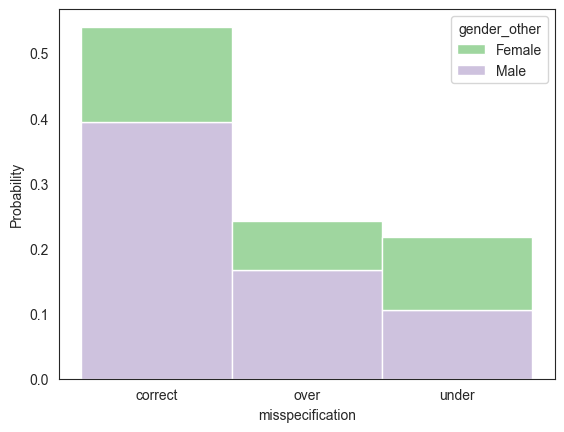

In [613]:
sns.histplot(data=stereo_characteristics_beliefs, x='misspecification',  hue='gender_other', discrete=True, stat='probability', multiple='stack')

In [596]:
characteristics = stereo_characteristics_beliefs
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='over', 1, 0)
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='correct', 0,  characteristics['misspecification_num'])
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='under', -1,  characteristics['misspecification_num'])

(0.0, 1.0)

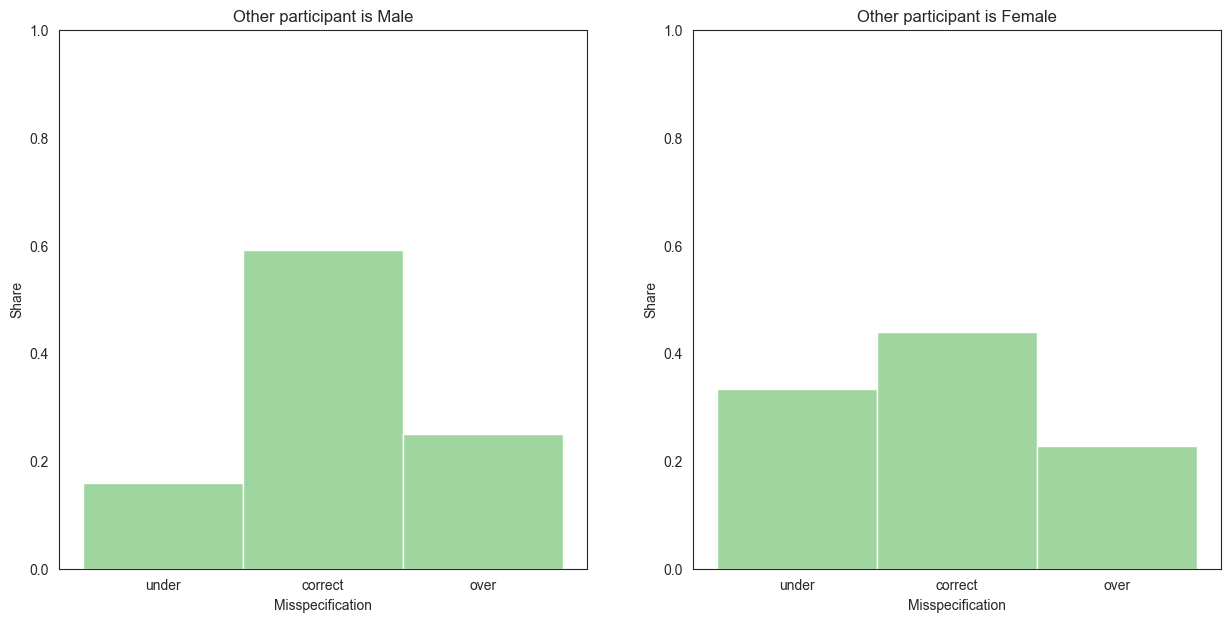

In [614]:

# make 2 plots side by side of the misspecification distribution for each of the gender_other
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data = characteristics[characteristics['gender_other']=='Male'], x='misspecification_num', discrete=True, stat='probability', multiple='stack', ax=axs[0])
axs[0].set_title('Other participant is Male')
axs[0].set_ylabel('Share')
axs[0].set_xlabel('Misspecification')
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim((0, 1))
sns.histplot(data = characteristics[characteristics['gender_other']=='Female'], x='misspecification_num', discrete=True, stat='probability', multiple='stack', ax=axs[1])
axs[1].set_title('Other participant is Female')
axs[1].set_ylabel('Share')
axs[1].set_xlabel('Misspecification')
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim((0, 1))





Text(0.5, 0.98, 'score beliefs about other participant by topic')

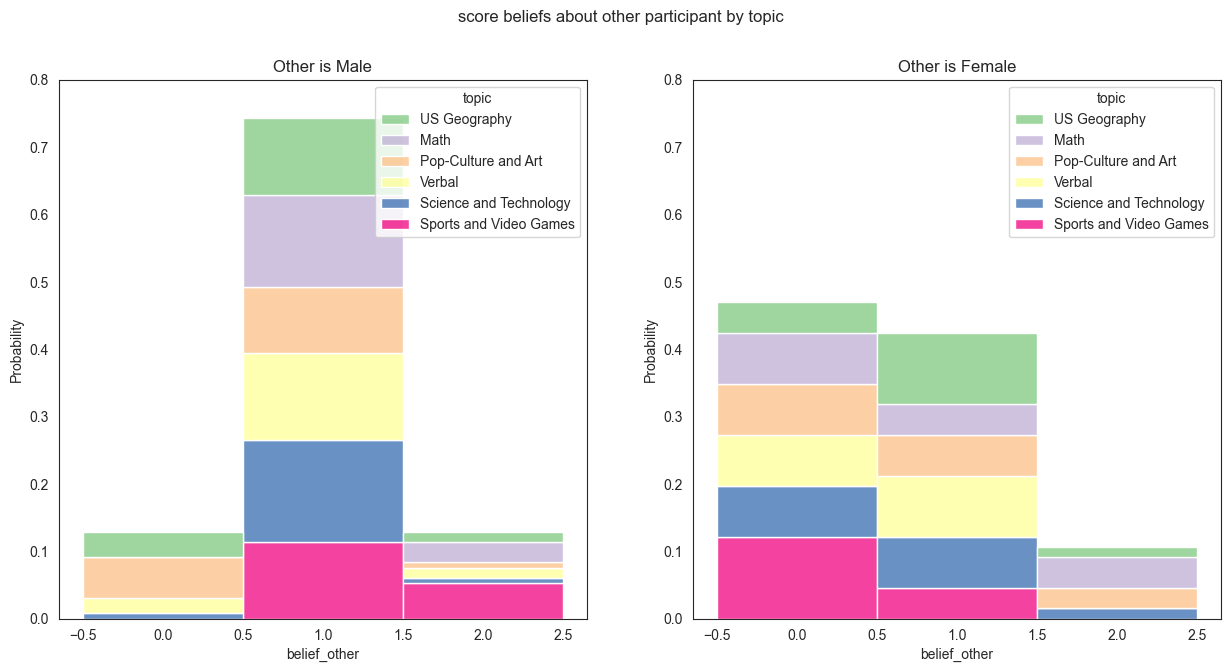

In [598]:
# make 2 plots side by side of the misspecification distribution for each of the gender_other
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data = characteristics[characteristics['gender_other']=='Male'], x='belief_other', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[0])
axs[0].set_title('Other is Male')
axs[0].set_ylim((0, .8))
sns.histplot(data = characteristics[characteristics['gender_other']=='Female'], x='belief_other', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[1])
axs[1].set_title('Other is Female')
axs[1].set_ylim((0, .8))
fig.suptitle('score beliefs about other participant by topic')

Text(0.5, 0.98, 'misspecification about other participant by topic')

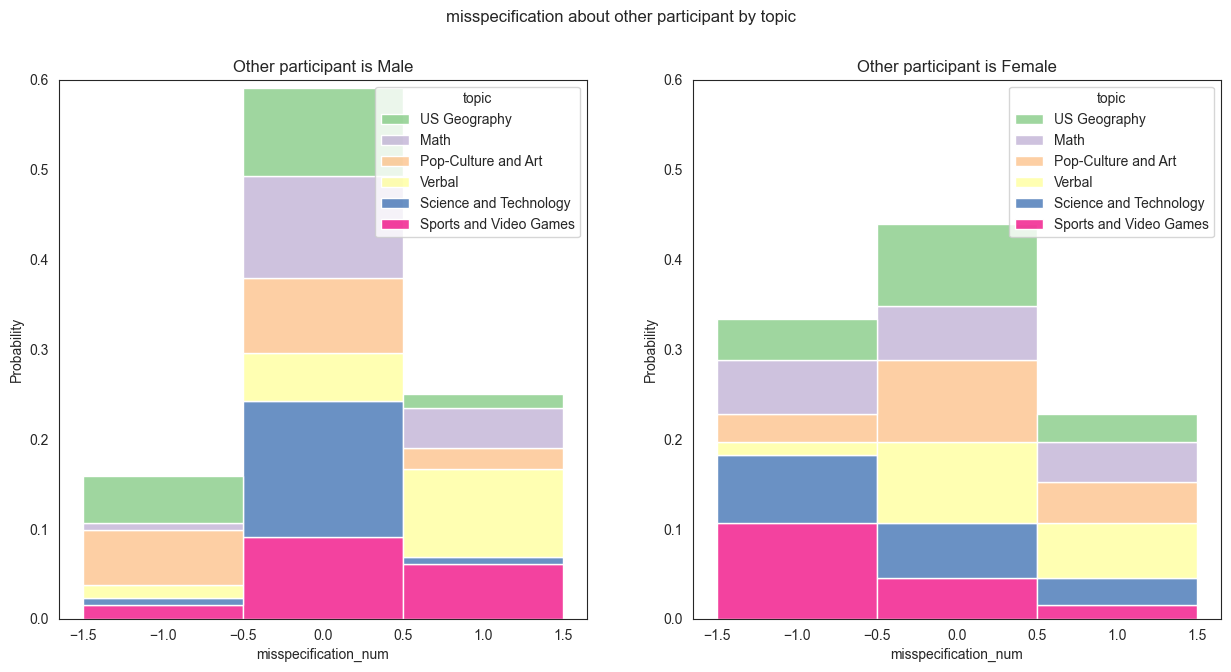

In [599]:
# make 2 plots side by side of the misspecification distribution for each of the gender_other
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data = characteristics[characteristics['gender_other']=='Male'], x='misspecification_num', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[0])
axs[0].set_title('Other participant is Male')
axs[0].set_ylim((0, .6))
sns.histplot(data = characteristics[characteristics['gender_other']=='Female'], x='misspecification_num', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[1])
axs[1].set_title('Other participant is Female')
axs[1].set_ylim((0, .6))
fig.suptitle('misspecification about other participant by topic')

Text(0.5, 0.98, 'misspecification about other participant by topic')

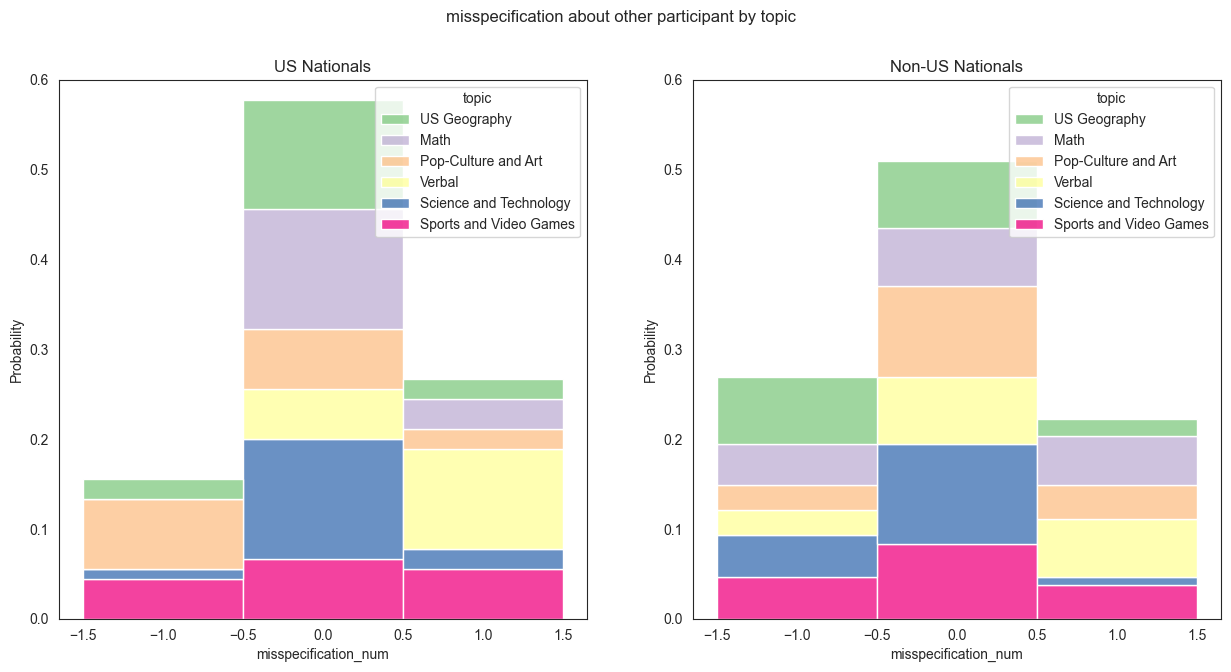

In [600]:
# make 2 plots side by side of the misspecification distribution for each of the nationality_other
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data = characteristics[characteristics['nationality_other']=='US National'], x='misspecification_num', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[0])
axs[0].set_title('US Nationals')
axs[0].set_ylim((0, .6))
sns.histplot(data = characteristics[characteristics['nationality_other']=='non-US National'], x='misspecification_num', hue='topic',
             discrete=True, stat='probability', multiple='stack', ax=axs[1])
axs[1].set_title('Non-US Nationals')
axs[1].set_ylim((0, .6))
fig.suptitle('misspecification about other participant by topic')

Text(0, 0.5, 'Belief/type')

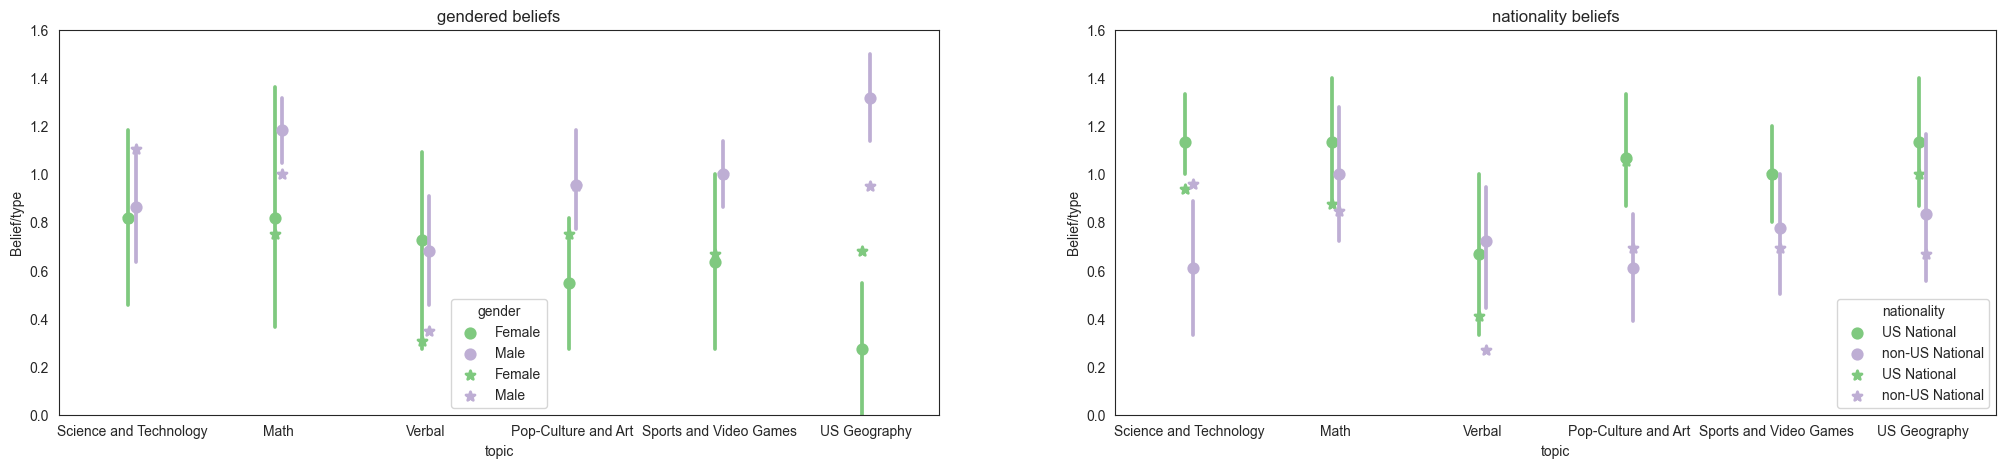

In [601]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.pointplot(data=characteristics, x='topic', y='belief_other', hue='gender_other', dodge=True, join=False, ax=axs[0], hue_order=['Female', 'Male'])

sns.pointplot(data=updates[updates['treatment']=='ego'], x='topic', y='theta', hue='gender', 
              markers='*', dodge=True, join=False, ax=axs[0], errorbar=None, hue_order=['Female', 'Male'])
axs[0].set_title('gendered beliefs')
axs[0].set_ylim((0, 1.6))
axs[0].set_ylabel('Belief/type')

#plot the average belief b topic and nationality_other
sns.pointplot(data=characteristics, x='topic', y='belief_other', hue='nationality_other', dodge=True, join=False, ax=axs[1], 
              hue_order=['US National', 'non-US National'])

sns.pointplot(data=updates[updates['treatment']=='ego'], x='topic', y='theta', hue='nationality', 
              markers='*', dodge=True, join=False, ax=axs[1], errorbar=None, hue_order=['US National', 'non-US National'])
axs[1].set_title('nationality beliefs')
axs[1].set_ylim((0, 1.6))
axs[1].set_ylabel('Belief/type')



/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/1306574476.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gender_nationality = characteristics.groupby(['gender_other', 'nationality_other']).mean()['belief_other']


Text(0.5, 1.0, 'believed scores by characteristics')

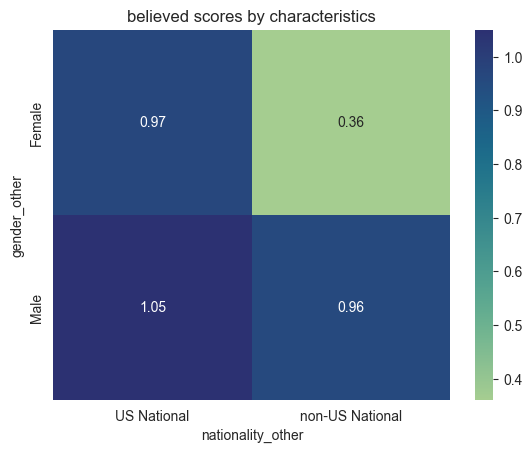

In [602]:
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality = characteristics.groupby(['gender_other', 'nationality_other']).mean()['belief_other']

gender_nationality= gender_nationality.unstack()

sns.heatmap(gender_nationality, annot=True, cmap='crest', fmt='.2f')
plt.title('believed scores by characteristics')



Text(0.5, 1.0, 'believed scores by characteristics')

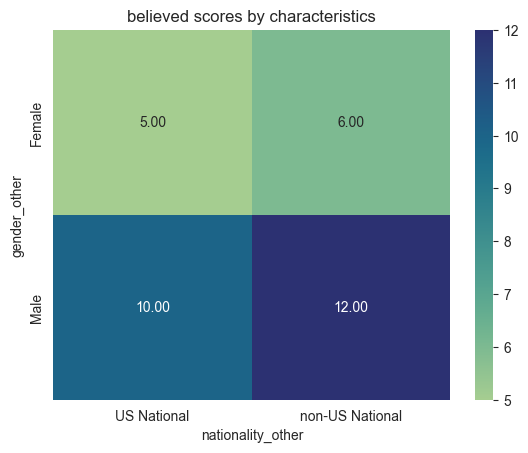

In [603]:
# number of participants in each category
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality = characteristics.groupby(['gender_other', 'nationality_other']).count()['belief_other']/6

gender_nationality= gender_nationality.unstack()

sns.heatmap(gender_nationality, annot=True, cmap='crest', fmt='.2f')
plt.title('believed scores by characteristics')

In [604]:
topics = characteristics['topic'].unique()

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/312548757.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gender_nationality_0 = characteristics[characteristics['topic']==topics[0]].groupby(['gender_other', 'nationality_other']).mean()['belief']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/312548757.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gender_nationality_1 = characteristics[characteristics['topic']==topics[1]].groupby(['gender_other', 'nationality_other']).mean()['belief']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/312548757.py:1

Text(0.5, 1.0, 'Sports and Video Games')

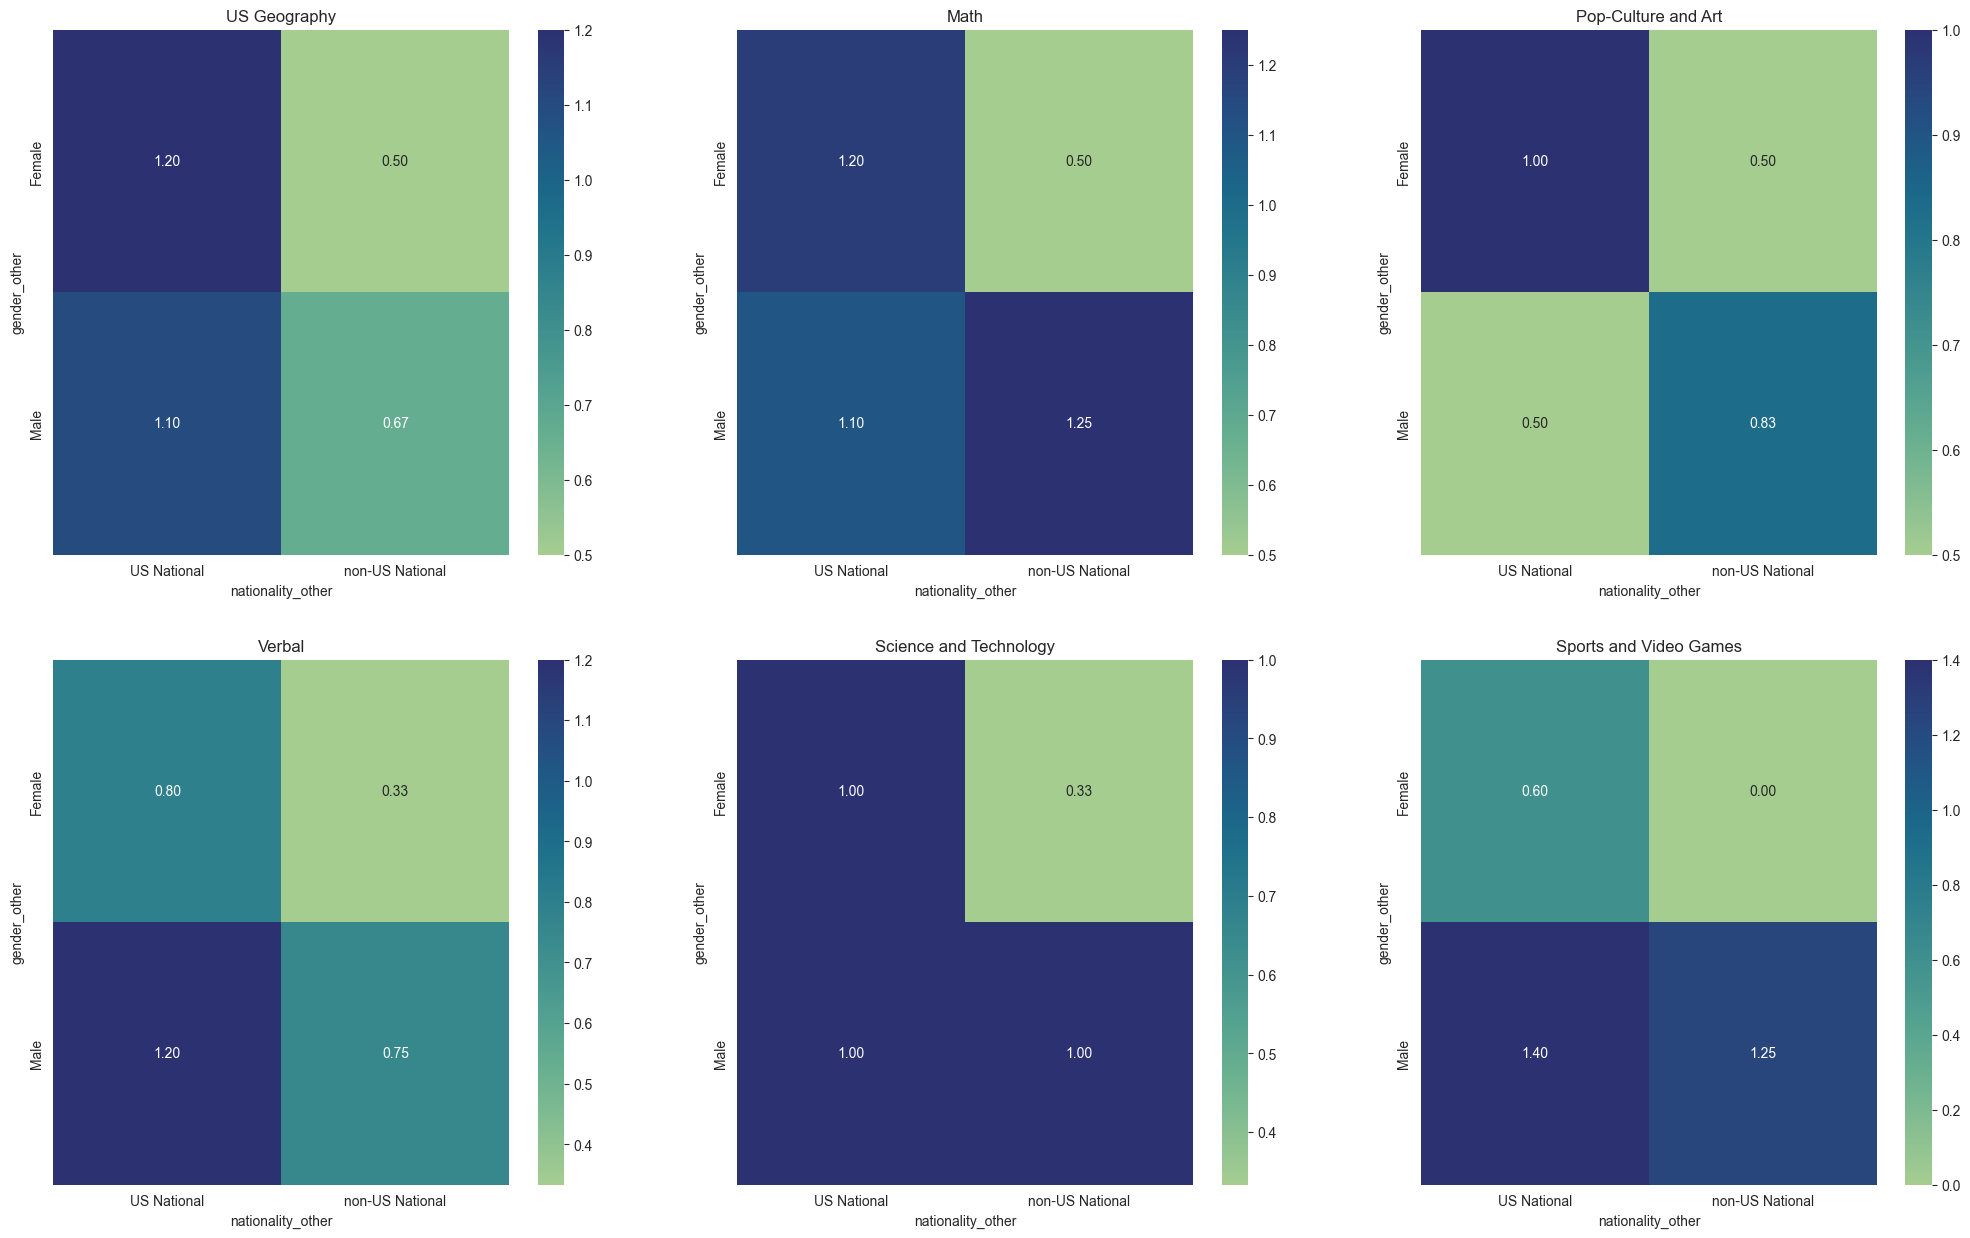

In [605]:
# make a heat map of the belief_other by gender_other and nationality_other for each topic
fig, axs = plt.subplots(2, 3, figsize=(25, 15))
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality_0 = characteristics[characteristics['topic']==topics[0]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_0= gender_nationality_0.unstack()

sns.heatmap(gender_nationality_0, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title(topics[0])

gender_nationality_1 = characteristics[characteristics['topic']==topics[1]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_1= gender_nationality_1.unstack()

sns.heatmap(gender_nationality_1, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 1])
axs[0, 1].set_title(topics[1])

gender_nationality_2 = characteristics[characteristics['topic']==topics[2]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_2= gender_nationality_2.unstack()

sns.heatmap(gender_nationality_2, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 2])
axs[0, 2].set_title(topics[2])

gender_nationality_3 = characteristics[characteristics['topic']==topics[3]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_3= gender_nationality_3.unstack()

sns.heatmap(gender_nationality_3, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 0])
axs[1, 0].set_title(topics[3])

gender_nationality_4 = characteristics[characteristics['topic']==topics[4]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_4= gender_nationality_4.unstack()

sns.heatmap(gender_nationality_4, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 1])
axs[1, 1].set_title(topics[4])

gender_nationality_5 = characteristics[characteristics['topic']==topics[5]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_5= gender_nationality_5.unstack()

sns.heatmap(gender_nationality_5, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 2])
axs[1, 2].set_title(topics[5])


/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/3854755948.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['belief_other']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/3854755948.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['theta']


Text(1089.8989898989896, 0.5, '')

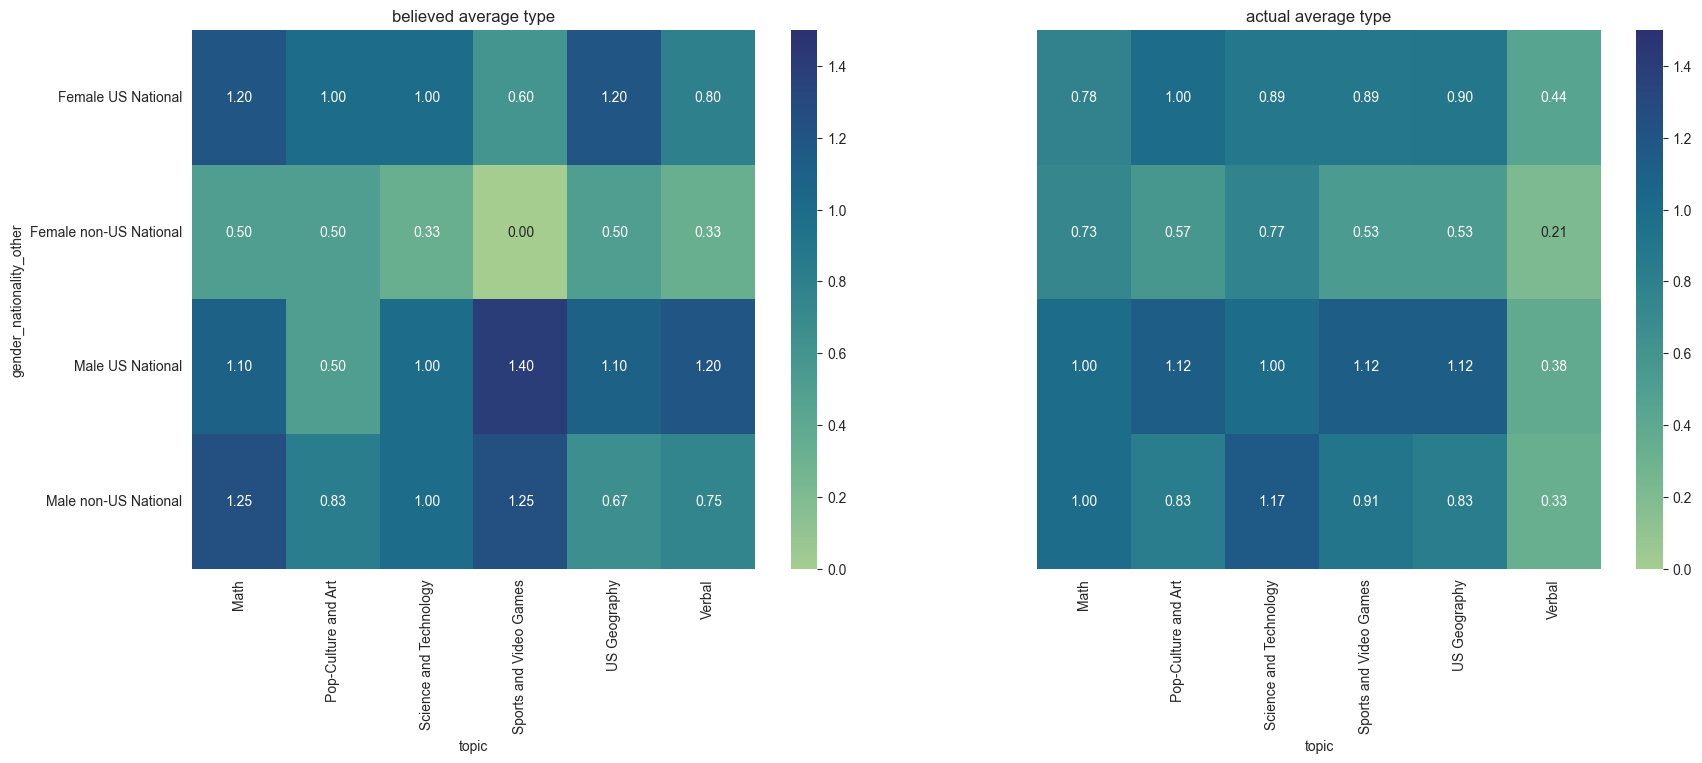

In [606]:
characteristics['gender_nationality_other']=characteristics['gender_other']+' '+ characteristics['nationality_other']

# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['belief_other']

topic_charact= topic_charact.unstack()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', ax=axs[0], cbar=True, vmin=0, vmax=1.5)
axs[0].set_title('believed average type')

# the true average scores
updates['gender_nationality'] = updates['gender'] + ' ' + updates['nationality']

# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['theta']

topic_charact= topic_charact.unstack()

sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', ax=axs[1], yticklabels=False, vmin=0, vmax=1.5)
axs[1].set_title('actual average type')
axs[1].set_ylabel('')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/2546764377.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['misspecification_num']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/2546764377.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['misspecification_num']


Text(0.5, 0.98, 'misspecifications by topic and characteristics before feedback')

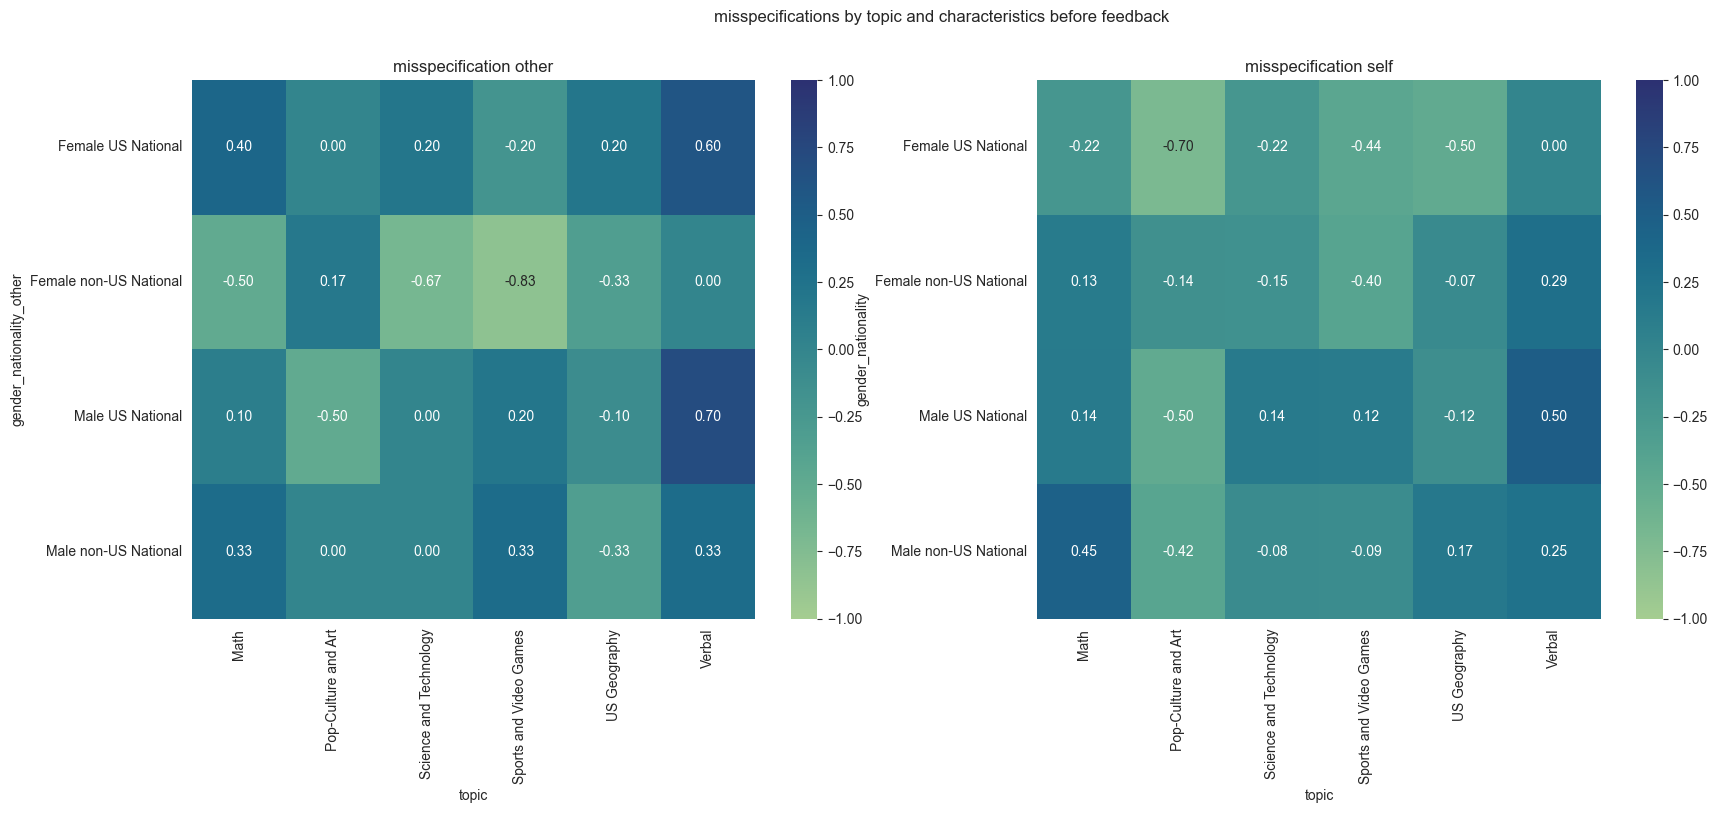

In [607]:
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['misspecification_num']

topic_charact= topic_charact.unstack()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', cbar=True, vmin=-1, vmax=1, ax=axs[0])
axs[0].set_title('misspecification other')

topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['misspecification_num']

topic_charact= topic_charact.unstack()
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', cbar=True, vmin=-1, vmax=1, ax=axs[1])
axs[1].set_title('misspecification self')

plt.suptitle('misspecifications by topic and characteristics before feedback')

# Correlation belief_self and belief_other

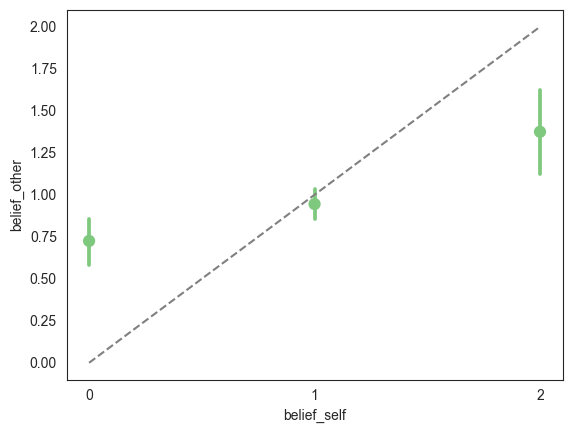

In [608]:
sns.pointplot(data=characteristics, x='belief_self', y='belief_other', dodge=True, join=False)
# add the identity line
plt.plot([0, 2], [0, 2], color='gray', linestyle='--')

# Evolution of misspecifications

Text(0.5, 1.0, 'Average misspecification by round number')

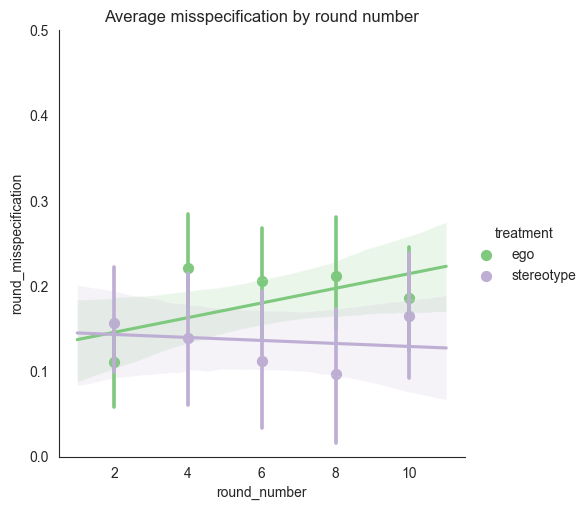

In [609]:
# plot the average misspecification by round_number
sns.lmplot(data=updates, x='round_number', y='round_misspecification', x_bins=5, hue='treatment', hue_order=['ego', 'stereotype'])
plt.ylim((0, .5))
plt.title('Average misspecification by round number')


Text(0.5, 1.0, 'Average misspecification by round number and omega')

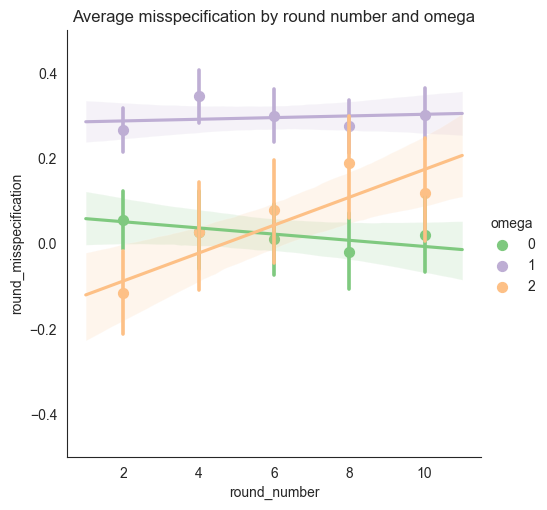

In [610]:
# plot the average misspecification by round_number and by omega
sns.lmplot(data=updates, x='round_number', y='round_misspecification', x_bins=5, hue='omega', hue_order=[0, 1, 2])
plt.ylim((-.5, .5))
plt.title('Average misspecification by round number and omega')

# Compute the Likelihoods

In [ ]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in [a+2 for a in range(10)]:
        
        e_t = int(player.loc[player['round_number']==t, 'effort'])
        theta = int(player.loc[player['round_number']==t, 'theta'])
        belief_prev = int(player.loc[player['round_number']==t-1, 'last_button'])
        belief_new = int(player.loc[player['round_number']==t, 'last_button'])
        omega = int(player.loc[player['round_number']==t, 'omega'])
        s_t = int(player.loc[player['round_number']==t, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_new = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0))))
        posterior_prev = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0))))

        p_new = sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)@posterior_new
        p_prev = sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)@posterior_prev
        # multiply all the elements in p_true and p_belief
        l_new = np.prod(p_new)
        l_prev = np.prod(p_prev)
        # calculate the likelihood ratio
        lr_t.append(l_new/l_prev)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[(updates['player_code']==c) & (updates['round_number']>=2), 'lr'] = lr_t

# Compute alpha


In [ ]:
len(updates.loc[(updates['lr']>15), 'lr'])/len(updates['lr'])

0.004049402713099818

In [ ]:
# calculate the average of lr for the rows in which change_indicator is 1 
# (dropping paths in which subjects changed their belief more than 9 times)
alpha = updates.loc[(updates['change_indicator']==1)& (updates['change_indicator_sum']<=9) & (updates['lr']<=15), 'lr'].mean()
alpha

1.49975994558159

In [ ]:
# calculate alpha for each treatment separately, still dropping paths in which subjects changed their belief more than 9 times
alpha_ego = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='ego')& (updates['lr']<15), 'lr'].mean()
alpha_stereo = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='stereotype')& (updates['lr']<15), 'lr'].mean()

print('alpha is ' + str(alpha_ego) + 'in the ego condition')
print('alpha is ' + str(alpha_stereo) + 'in the stereotype condition')

alpha is 1.5522613274692916in the ego condition
alpha is 1.44192920531297in the stereotype condition


## Test if the alphas are different in the two treatments

In [ ]:
stats.ttest_ind(updates.loc[(updates['treatment']=='ego') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<15) , 'lr'], 
                updates.loc[(updates['treatment']=='stereotype') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<15) , 'lr'])

Ttest_indResult(statistic=1.0037715420639035, pvalue=0.31566690780265233)

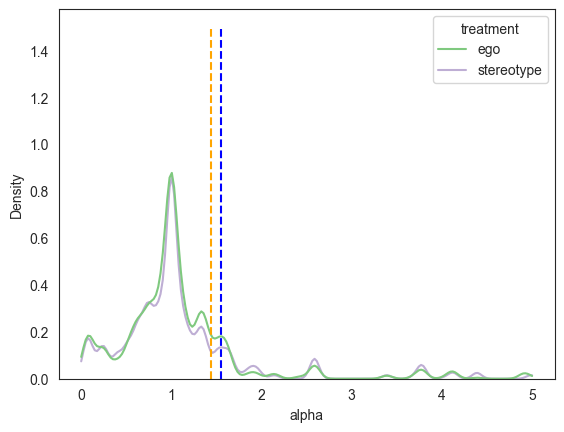

In [ ]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<=15)], x = 'lr', 
            hue='treatment', bw_adjust=.1, clip=(0, 5))
plt.xlabel('alpha')
# plt.vlines([alpha], 0, 1.5, color = 'gray', linestyles='--')
plt.vlines([alpha_ego], 0, 1.5, color = 'blue', linestyles='--', label=('ego mean'))
plt.vlines([alpha_stereo], 0, 1.5, color = 'orange', linestyles='--', label=('stereo mean'))


In [ ]:
alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()
alpha_subjects.reset_index(inplace=True)

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/2835870841.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()


<Axes: xlabel='lr', ylabel='Count'>

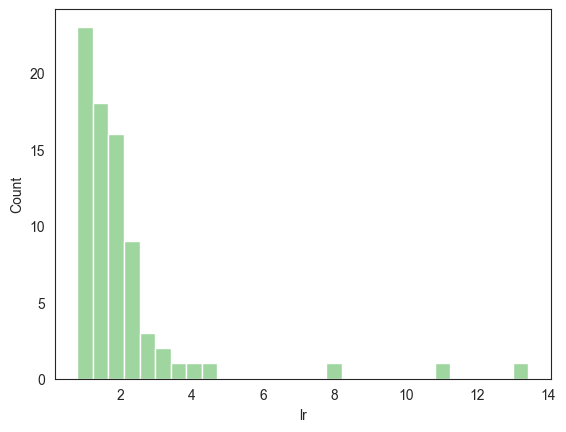

In [ ]:
sns.histplot(data = alpha_subjects[alpha_subjects['lr']<15], x = 'lr')

Text(0.5, 1.0, 'Number of belief changes by initial misspecification')

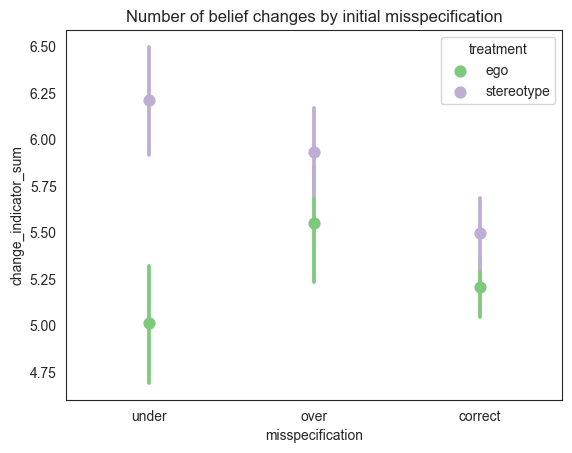

In [ ]:
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9)], y='change_indicator_sum', x='misspecification', join =False, hue='treatment')
plt.title('Number of belief changes by initial misspecification')

# Disaggregate Alpha

Text(0.5, 1.0, 'Switching Threshold by treatment')

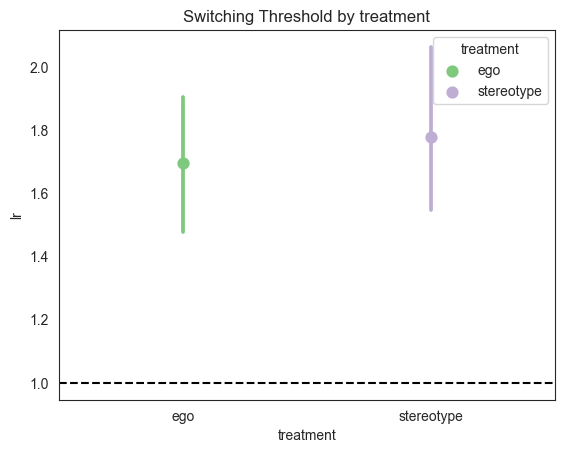

In [ ]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<50)], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

Text(0.5, 1.0, 'switching threshold by misspecifiaction')

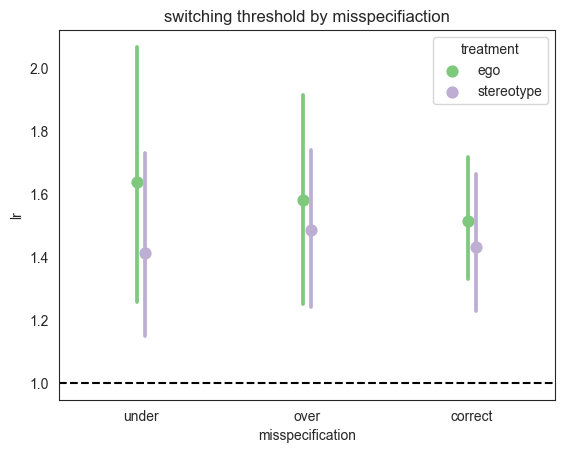

In [ ]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<15)], 
              y='lr', x='misspecification', join =False, hue='treatment', dodge=True)
plt.axhline(y=1, color='black', linestyle='--')
plt.title('switching threshold by misspecifiaction')

In [ ]:
#take code of the observations in which the 'lr' is grater than 50
codes = updates.loc[(updates['lr']>=50) & (updates['round_number']>2), 'player_code'].unique()
# get the data from the observations that have a player_code in codes
abnormals = updates[updates['player_code'].isin(codes)]

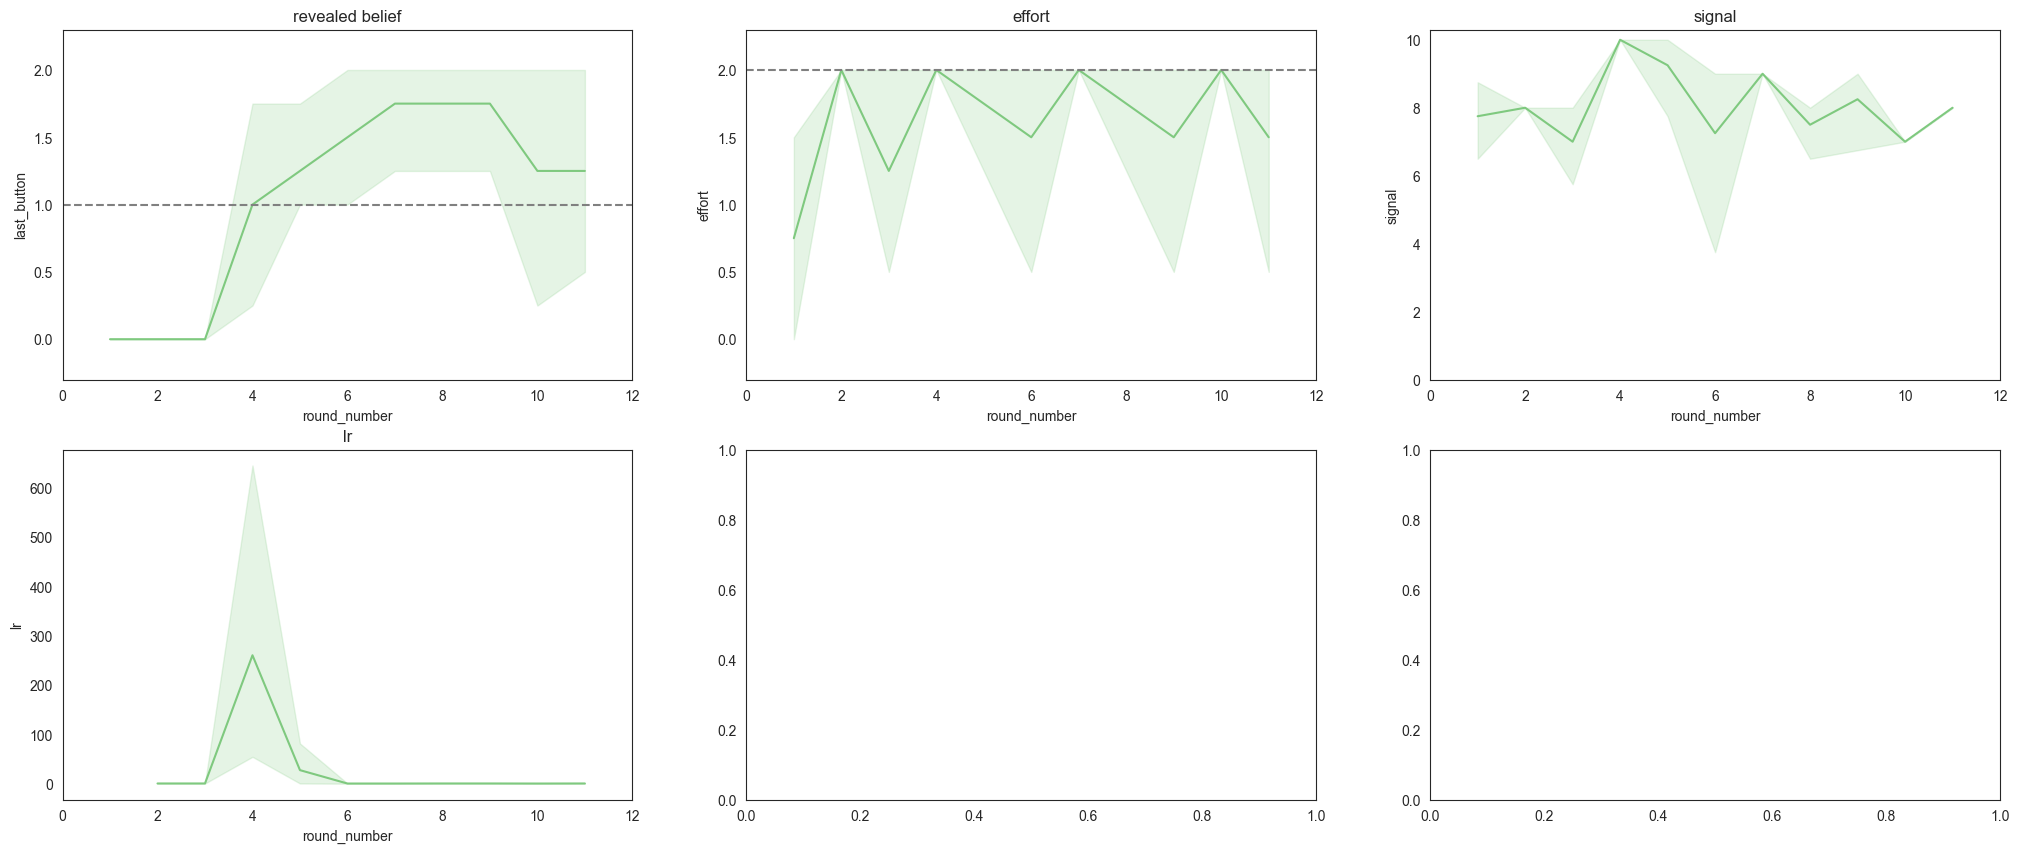

In [ ]:
# The paths whith the 4 highest values of lr (above 50)

fig, axs = plt.subplots(2, 3, figsize=(25, 10))

sns.lineplot(data=abnormals, x='round_number', y='last_button', ax=axs[0,0])
axs[0,0].set_title('revealed belief')
sns.lineplot(data=abnormals, x='round_number', y='effort', ax=axs[0,1])
axs[0,1].set_title('effort')
sns.lineplot(data=abnormals, x='round_number', y='signal', ax=axs[0,2])
axs[0,2].set_title('signal')
sns.lineplot(data=abnormals, x='round_number', y='lr', ax=axs[1,0])
axs[1,0].set_title('lr')

axs[0, 0].set_ylim((-0.3, 2.3))
axs[0, 1].set_ylim((-0.3, 2.3))
axs[0, 2].set_ylim((0, 10.3))


axs[0, 0].set_xlim((0, 12))
axs[0, 1].set_xlim((0, 12))
axs[0, 2].set_xlim((0, 12))
axs[1, 0].set_xlim((0, 12))

axs[0, 0].axhline(y=abnormals['theta'].mean(), linestyle='--', color='gray')
axs[0, 1].axhline(y=abnormals['omega'].mean(), linestyle='--', color='gray')

Text(0.5, 1.0, 'Switching Threshold by topic')

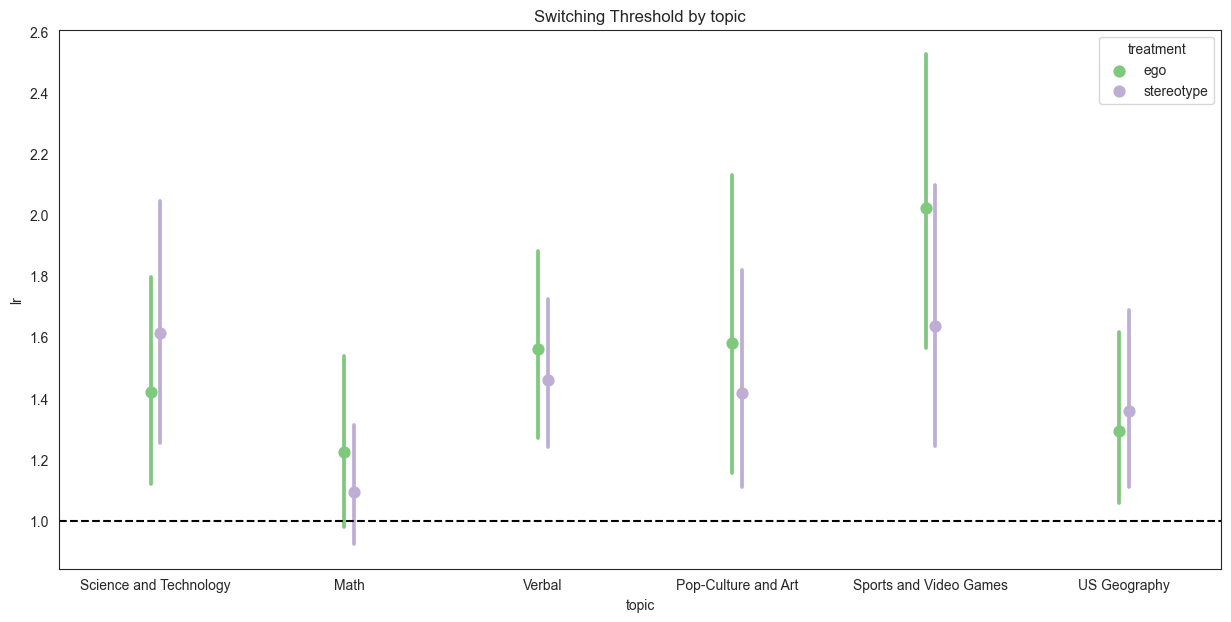

In [ ]:
# plot the estimates of alpha by topic
axs, fig = plt.subplots(1,1, figsize=(15, 7))
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<15)], 
              y='lr', x='topic', join =False, hue='treatment', dodge=True)

plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by topic')


# Add the simulation data and reshape to merge to the experiment's data

In [ ]:
# import the simulation data
sim = pd.read_csv("../Simulations/demo/data/simulation.csv")

In [ ]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [ ]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [ ]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_bay', 'e_ss', 'e_joint', 'e_joint_ss', 'theta_lr_L', 'theta', 'omega', 'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_bay', 'e_ss', 'e_joint','e_joint_ss', 'theta_lr_M', 'theta', 'omega', 'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_bay', 'e_ss', 'e_joint', 'e_joint_ss', 'theta_lr_H', 'theta', 'omega', 'round_number_modif']]



In [ ]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind',
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving',
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving',
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number'})

In [ ]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [ ]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [ ]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

# The Simulations

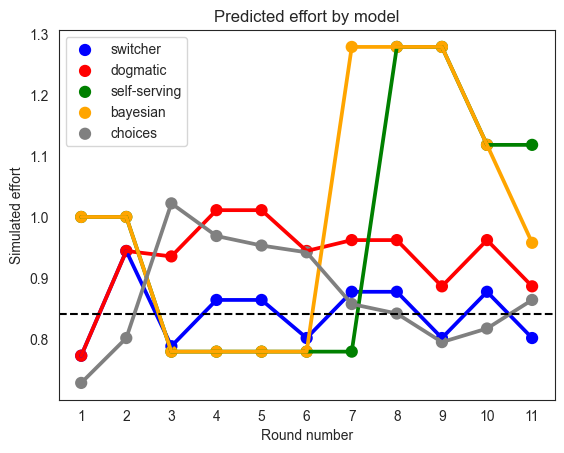

In [ ]:
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='switcher', label='switcher', color='blue', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='dogmatic', label='dogmatic', color='red', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='self-serving', label='self-serving', color='green', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='bayesian', label='bayesian', color='orange', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='effort', label='choices', color='gray', errorbar=None)

# add a horizontal line at  the average omega
plt.axhline(y=updates['omega'].mean(), color='black', linestyle='--')
plt.ylabel('Simulated effort')
plt.xlabel('Round number')
plt.title('Predicted effort by model')
plt.legend()


In [ ]:
# add a column called misspecification to the data frame sim which is -1 if belief is lower than theta, 0 if they are the same and 1 if belief is higher than theta
sim.loc[sim['switcher_belief']<sim['theta'], 'misspecification'] = -1
sim.loc[sim['switcher_belief']==sim['theta'], 'misspecification'] = 0
sim.loc[sim['switcher_belief']>sim['theta'], 'misspecification'] = 1

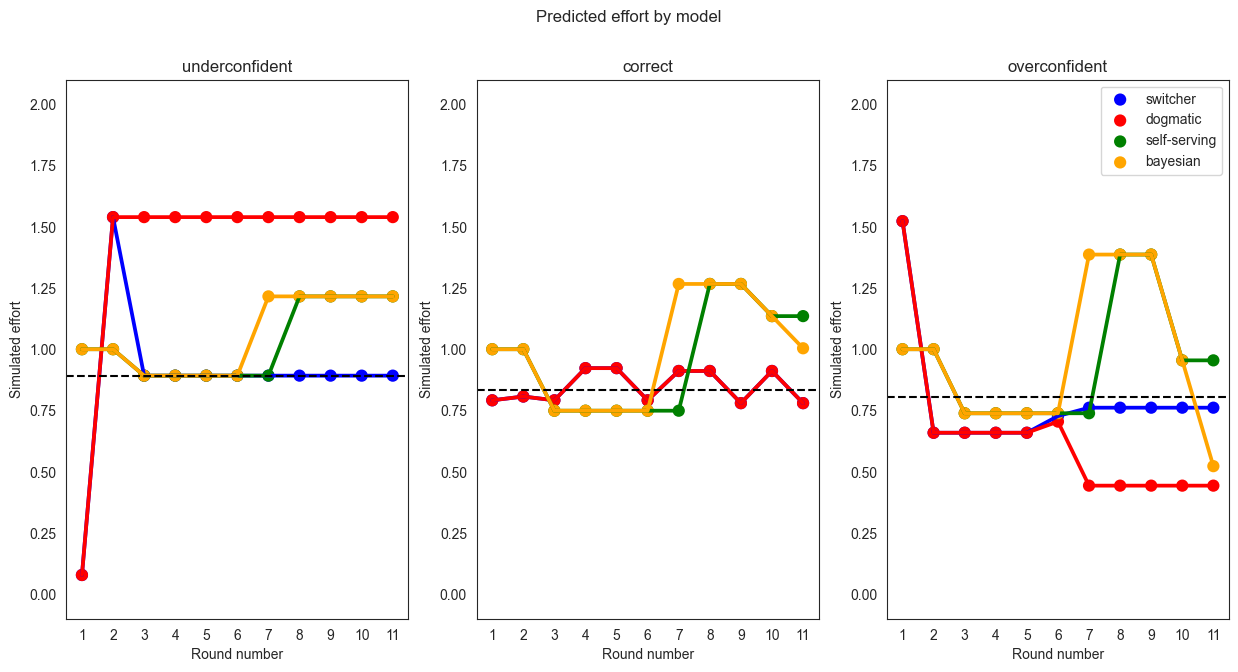

In [ ]:
# plot the predictions of each model in the case of over confidence, correct and under confidence
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Predicted effort by model')
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[0], errorbar=None)

# add a horizontal line at  the average omega
axs[0].axhline(y=updates.loc[updates['misspecification']=='under', 'omega'].mean(), color='black', linestyle='--')
axs[0].set_ylabel('Simulated effort')
axs[0].set_xlabel('Round number')
axs[0].set_title('underconfident')
axs[0].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[1], errorbar=None)

# add a horizontal line at  the average omega
axs[1].axhline(y=updates.loc[updates['misspecification']=='correct', 'omega'].mean(), color='black', linestyle='--')
axs[1].set_ylabel('Simulated effort')
axs[1].set_xlabel('Round number')
axs[1].set_title('correct')
axs[1].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[2], errorbar=None)

# add a horizontal line at  the average omega
axs[2].axhline(y=updates.loc[updates['misspecification']=='over', 'omega'].mean(), color='black', linestyle='--')
axs[2].set_ylabel('Simulated effort')
axs[2].set_xlabel('Round number')
axs[2].set_title('overconfident')
axs[2].set_ylim(-.1, 2.1)

axs[2].legend()

# Distance to each model

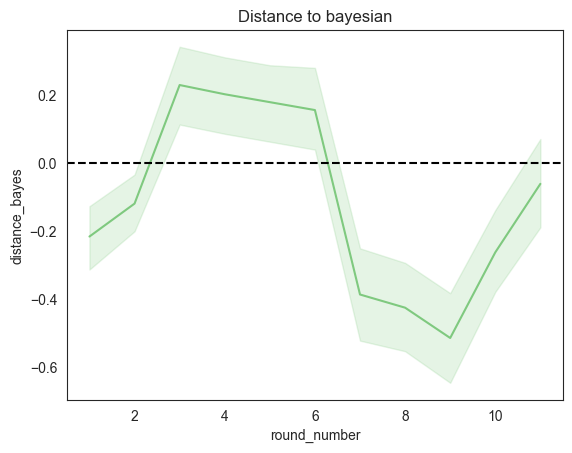

In [ ]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Distance to bayesian')

plt.savefig('../figures/distance_bayes.png', dpi=300)

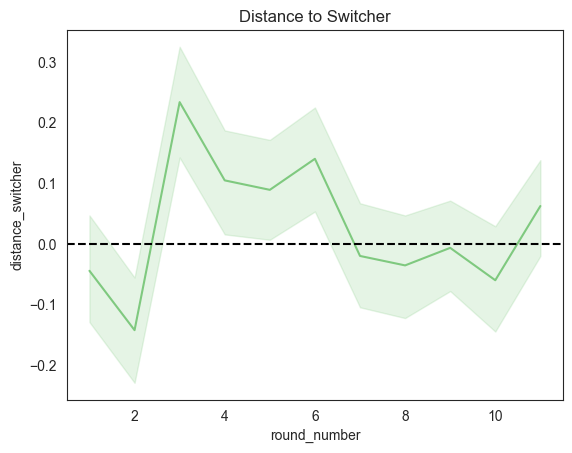

In [ ]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../figures/distance_switcher.png')

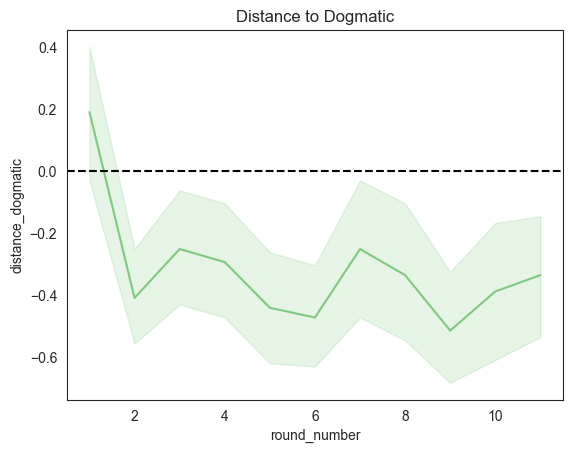

In [ ]:
# the dogmatic model only applies to a subset of cases. I take only those in a different data frame called dogmatic_updates
dogmatic_updates = updates[(updates['theta']==0) & (updates['omega']==2) & (updates['belief']==1)|
                           (updates['theta']==1) & (updates['omega']==0) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==2)|
                           (updates['theta']==1) & (updates['omega']==2) & (updates['belief']==2)|
                           (updates['theta']==2) & (updates['omega']==1) & (updates['belief']==1)]

# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../figures/distance_dogmatic.png')

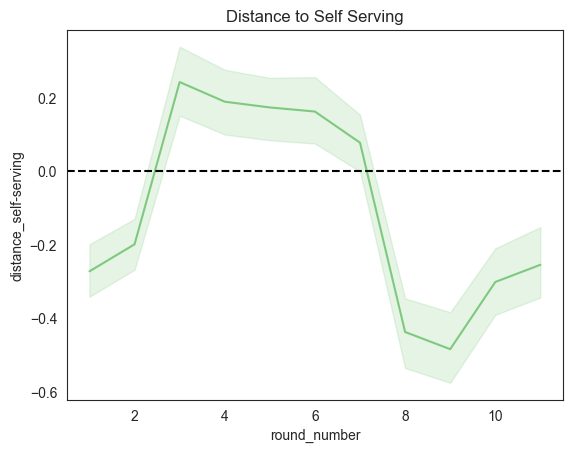

In [ ]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../figures/distance_self-serving.png')

In [ ]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot(updates, t, o)
        plt.savefig('../figures/updates_'+str(t)+str(o)+'.png')
        plt.close()

In [ ]:
# create a function that takes in theta and omega and the data and returns 8 plots and plots each treatment separately
def plot_treatment(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [ ]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot_treatment(updates, t, o)
        plt.savefig('../figures/updates_by_treatment'+str(t)+str(o)+'.png')
        plt.close()

# The paths predicted by self-serving by theta and omega


# Try to Classify subjects based on their behavior

In [ ]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates = updates.merge(distances, on='code', how='left')

In [ ]:
# make a data frame with the average distances by subject.
subject_models=updates.groupby(['code', 'treatment']).mean('best_model')
subject_models.reset_index(inplace=True)


In [ ]:
# for each subject, take the average distance of the best fittig model and set it in a new column
subject_models.loc[subject_models['best_model']==0, 'min_distance'] = subject_models.loc[subject_models['best_model']==0, 'distance_switcher_sum']
subject_models.loc[subject_models['best_model']==1, 'min_distance'] = subject_models.loc[subject_models['best_model']==1, 'distance_dogmatic_sum']
subject_models.loc[subject_models['best_model']==2, 'min_distance'] = subject_models.loc[subject_models['best_model']==2, 'distance_bayesian_sum']
subject_models.loc[subject_models['best_model']==3, 'min_distance'] = subject_models.loc[subject_models['best_model']==3,'distance_self-serving_sum']


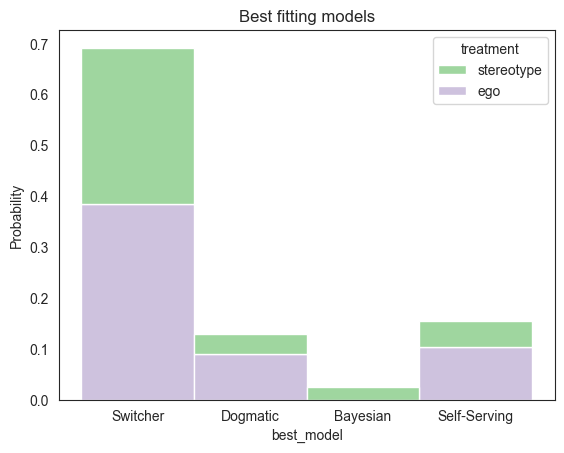

In [ ]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='stack', stat='probability')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')
plt.savefig('../figures/model_fit_histogram.png')

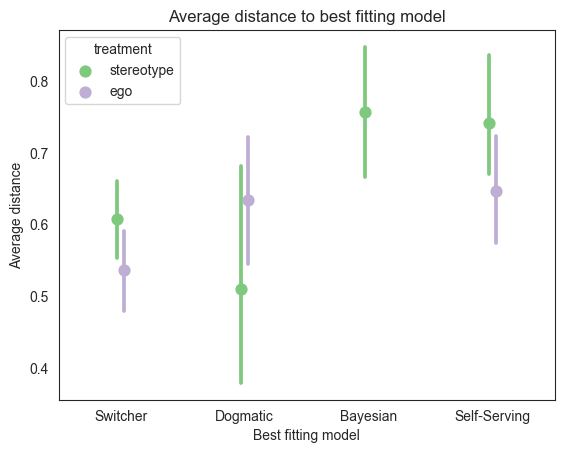

In [ ]:
# plot the average minimal distance for each of the models
subject_models['min_distance_avg'] = subject_models['min_distance']/66
sns.pointplot(data=subject_models, x='best_model', y='min_distance_avg', join =False, hue='treatment', dodge=True)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Average distance to best fitting model')
plt.ylabel('Average distance')
plt.xlabel('Best fitting model')
plt.savefig('../figures/model_min_distance.png')

# Differences across topics

<Axes: xlabel='misspecification', ylabel='Probability'>

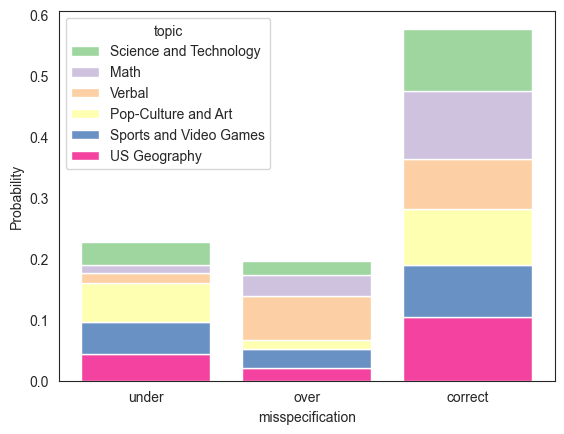

In [ ]:
sns.histplot(data=updates, x='misspecification', hue='topic', multiple='stack', stat='probability', shrink=.8, discrete=True)

<Axes: xlabel='misspecification', ylabel='certainty'>

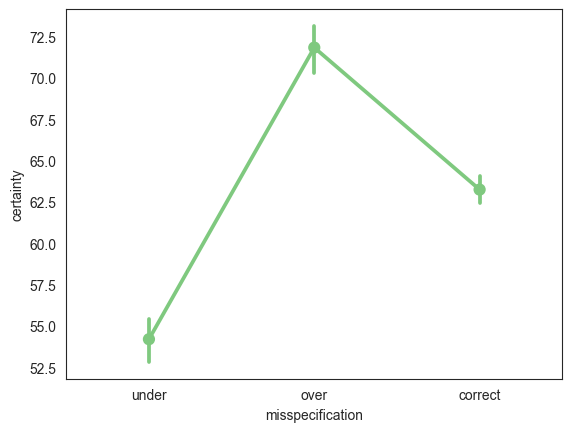

In [ ]:
sns.pointplot(data=updates, x='misspecification', y='certainty')

# Consistency in matrix choices

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/2671640152.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1.loc[:, 'consistent_first']=round_1['belief']==round_1['last_button']
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TtestResult(statistic=9.948842011226285, pvalue=3.3402212276198312e-21, df=448)

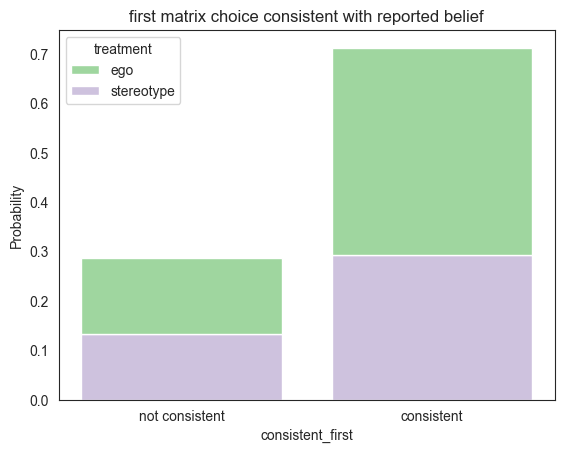

In [ ]:
# check if the fist matrix that they choose to see matches the belief they reported
# create a data frame with only round 1
round_1 = updates.loc[updates['round_number']==1, :]

# create a column that indicates whether the last_button in round 1 matches the reported belief
round_1.loc[:, 'consistent_first']=round_1['belief']==round_1['last_button']



sns.histplot(data=round_1, x='consistent_first', hue='treatment', multiple='stack', 
             discrete=True, stat='probability', shrink=.8)
plt.title('first matrix choice consistent with reported belief')
plt.xticks([0, 1], ['not consistent', 'consistent'])

plt.savefig('../figures/consistency_first.png')

np.mean(round_1['consistent_first'])

stats.ttest_1samp(round_1['consistent_first'], 0.5)

Text(0.5, 1.0, 'Best fitting models')

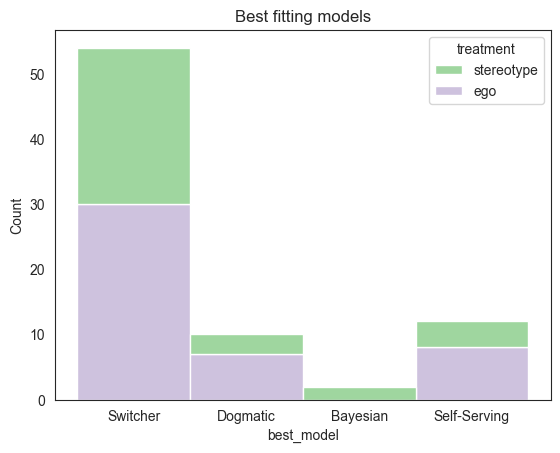

In [ ]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='stack')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')


# Choices relative to the optimal

In [616]:
updates.loc[updates['effort']==updates['omega'], 'correct_e'] = 1
updates.loc[updates['effort']!=updates['omega'], 'correct_e'] = 0

(0.0, 1.0)

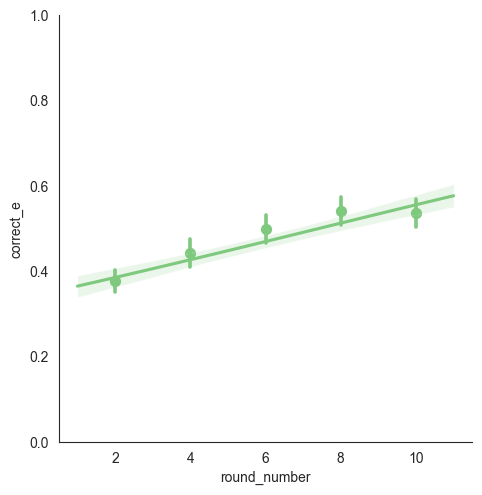

In [617]:
sns.lmplot(data=updates, x='round_number', y='correct_e', logistic=True, x_bins=5)
plt.ylim(0,1)

<Axes: xlabel='round_number', ylabel='correct_e'>

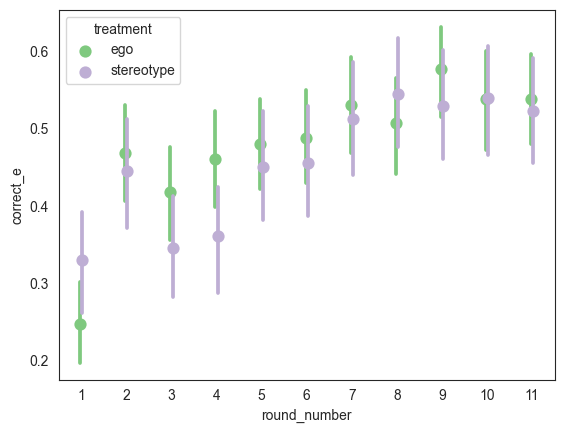

In [618]:
# plot the shatre of correct effort choices by round
sns.pointplot(data=updates, x='round_number', y='correct_e', join =False, hue='treatment', dodge=True)

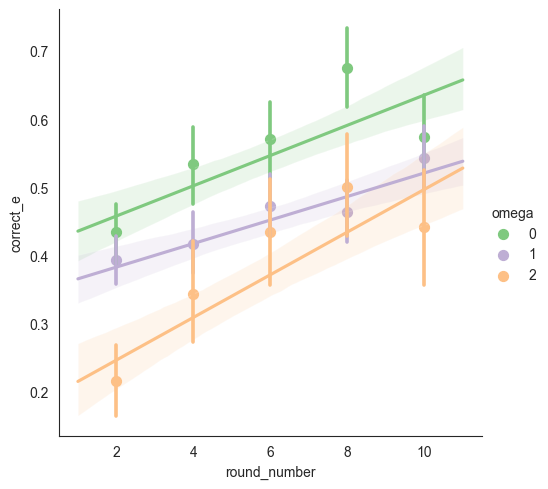

In [619]:
# plot the shatre of correct effort choices by round for each of the values of omega
sns.lmplot(data=updates, x='round_number', y='correct_e', hue='omega', x_bins=5)

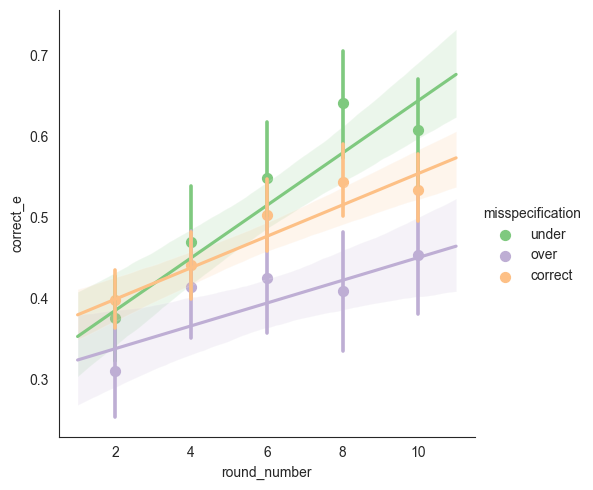

In [620]:
# plot the shatre of correct effort choices by round for each of the initial misspecifications
sns.lmplot(data=updates, x='round_number', y='correct_e', hue='misspecification', x_bins=5)

In [639]:
# plot the effort by signal in the previous round
# make a column called signal_prev that is the signal in the previous round
updates['signal_prev'] = updates.groupby('code')['signal'].shift(1)
# make a column called effort_change that is the change in effort from the previous round
# make a column called effort_prev with the effor from the previous round
updates['effort_prev'] = updates.groupby('code')['effort'].shift(1)
updates['effort_change'] = updates['effort'] - updates['effort_prev']

# good news is when the previous signal is higher than the average from before
# make a column in updates that is the average signal in all the previous rounds
updates['signal_avg'] = updates.groupby('code')['signal'].transform(lambda x: x.expanding().mean())
# make a column that the diference between the previous signal and the average
updates['news_diff'] = updates['signal_prev'] - updates['signal_avg']






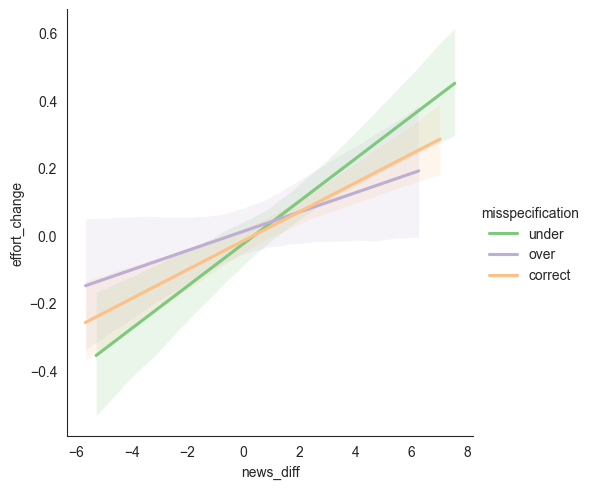

In [660]:
# plot the effort by signal in the previous round
sns.lmplot(data=updates[updates['round_number']>1], x='news_diff', y='effort_change', hue='misspecification', scatter=False)

In [646]:
# run a regression to check if the slopes are different
# create a column that is an indicator for the misspecification_over
updates['misspecification_over'] = 0
updates.loc[updates['misspecification']=='over', 'misspecification_over'] = 1
# create a colun that is an indicator for the misspecification_under
updates['misspecification_under'] = 0
updates.loc[updates['misspecification']=='under', 'misspecification_under'] = 1
# create a column that is an indicator for the misspecification_correct
updates['misspecification_correct'] = 0
updates.loc[updates['misspecification']=='correct', 'misspecification_correct'] = 1
# create columns for the interaction of each misspecification with the news_diff
updates['misspecification_over_news_diff'] = updates['misspecification_over']*updates['news_diff']
updates['misspecification_under_news_diff'] = updates['misspecification_under']*updates['news_diff']
updates['misspecification_correct_news_diff'] = updates['misspecification_correct']*updates['news_diff']

# run a regression with the interaction terms
results = smf.ols('effort_change ~ misspecification_over + misspecification_under + misspecification_correct + misspecification_over_news_diff + misspecification_under_news_diff + misspecification_correct_news_diff', data=updates[updates['round_number']>1]).fit()
print(results.summary())

# test if the estimated coefficients are different from eachother
 
hypotheses = 'misspecification_over_news_diff - misspecification_under_news_diff= 0, misspecification_under_news_diff - misspecification_correct_news_diff = 0, misspecification_correct_news_diff - misspecification_over_news_diff = 0'
t_test_slopes = results.t_test(hypotheses)

print(t_test_slopes.summary())


                            OLS Regression Results                            
Dep. Variable:          effort_change   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.035
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           7.69e-10
Time:                        18:16:45   Log-Likelihood:                -6236.2
No. Observations:                4490   AIC:                         1.249e+04
Df Residuals:                    4483   BIC:                         1.253e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

The underconfident subjects react more to more surprising news in effort. This means that they are attributing more of the news to the exogenous parameter than their own ability and thus. 

Instead, the overconfident subjects react the least, which might mean that they attribute more of the news to their own types. I will check separately for good and bad news to see if the updates are different there

Text(0.5, 1.0, 'reaction to bad news')

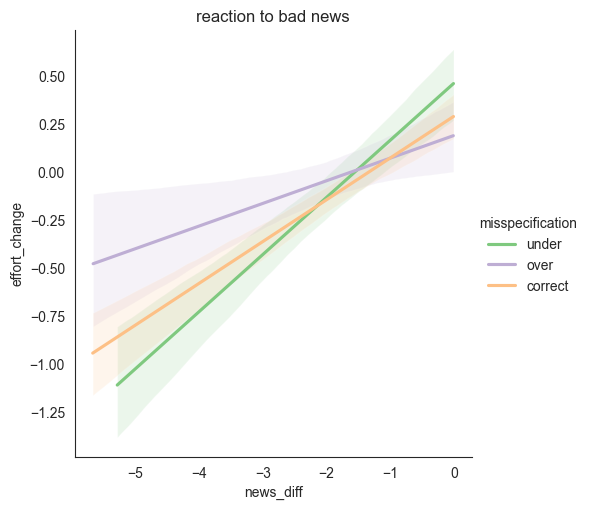

In [649]:
# plot the effort change by signal differential for good news and bad news separately
sns.lmplot(data=updates[(updates['round_number']>1) & (updates['news_diff']<0)], x='news_diff', y='effort_change', hue='misspecification', scatter=False)
plt.title('reaction to bad news')

The slope is positive for bad news, meaning, they react in effort to bad news 

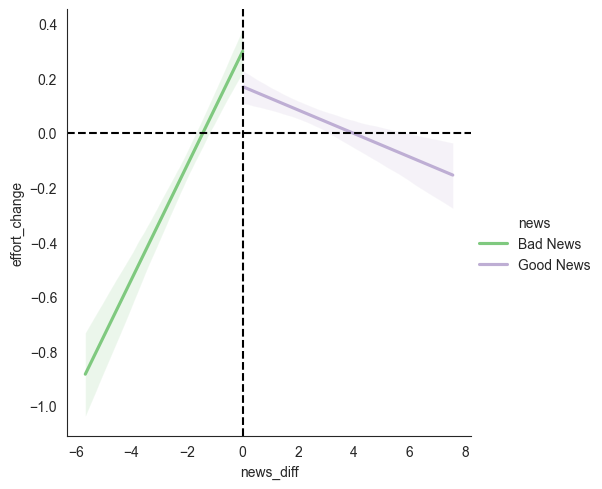

In [658]:
# create a column that takes the value 'Bad News' if news_diff is negative and 'Good News' if news_diff is positive
updates['news'] = 'Bad News'
updates.loc[updates['news_diff']>0, 'news'] = 'Good News'

# plot a regression of effort change on news_diff for each of the news
sns.lmplot(data=updates[updates['round_number']>1], x='news_diff', y='effort_change', hue='news', scatter=False)

# add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='--')

# add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')

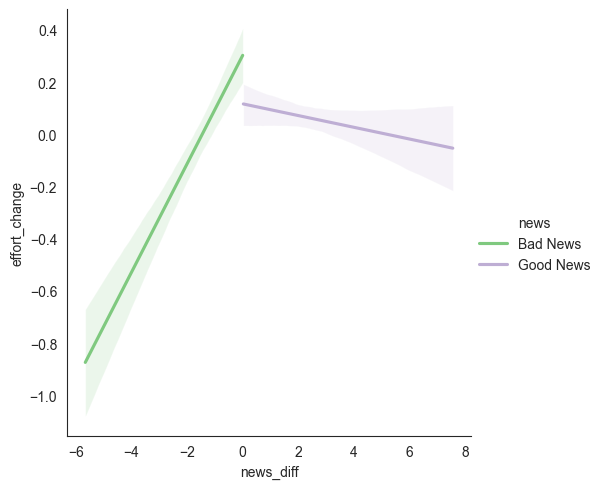

In [653]:
# do it for the ego treatment only
sns.lmplot(data=updates[(updates['round_number']>1) & (updates['treatment']=='ego')], x='news_diff', y='effort_change', hue='news', scatter=False)


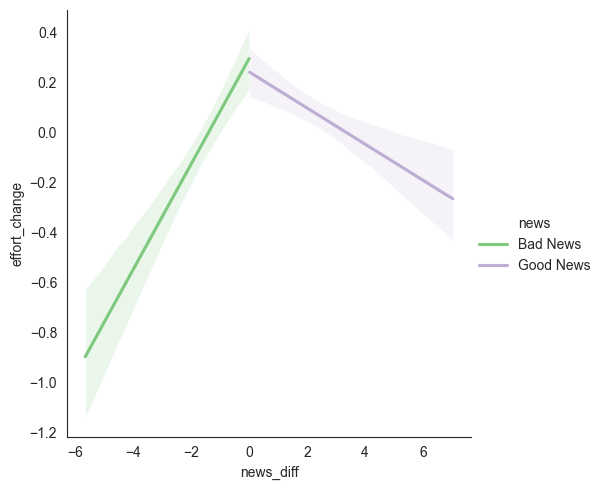

In [654]:
# do it for the stereotype treatment only
sns.lmplot(data=updates[(updates['round_number']>1) & (updates['treatment']=='stereotype')], x='news_diff', y='effort_change', hue='news', scatter=False)

In [632]:

updates[['code','round_number', 'signal', 'signal_avg']]

,code,round_number,signal,signal_avg
0,0m2xzxgv,1,1,1.000000
1,0m2xzxgv,2,3,2.000000
2,0m2xzxgv,3,0,1.333333
3,0m2xzxgv,4,3,1.750000
4,0m2xzxgv,5,2,1.800000
...,...,...,...,...
5143,zwzznpo6,7,8,4.951613
5144,zwzznpo6,8,5,4.952381
5145,zwzznpo6,9,5,4.953125
5146,zwzznpo6,10,2,4.907692


<Axes: xlabel='round_number', ylabel='correct_e'>

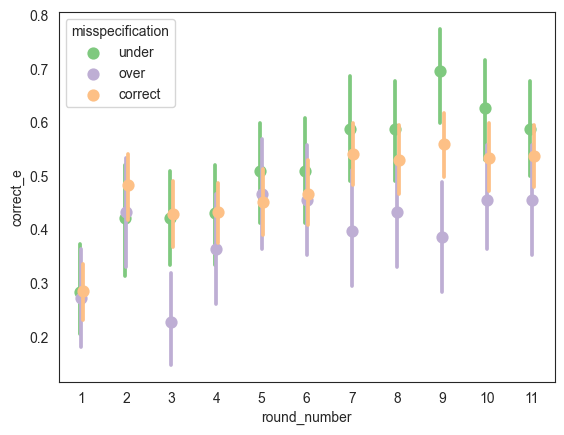

In [ ]:
# plot the shatre of correct effort choices by misspecification
sns.pointplot(data=updates, x='round_number', y='correct_e', join =False, hue='misspecification', dodge=True)

Text(0.5, 1.0, 'belief by round')

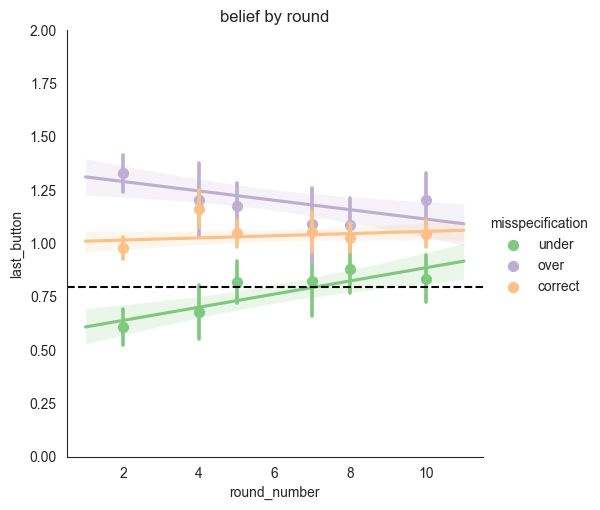

In [ ]:
# plot the linear model between rounds and last_button by misspecification
sns.lmplot(data=updates, x='round_number', y='last_button', x_bins=6, hue='misspecification')
plt.axhline(y=np.mean(updates['theta']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.title('belief by round')

<Axes: xlabel='belief', ylabel='certainty'>

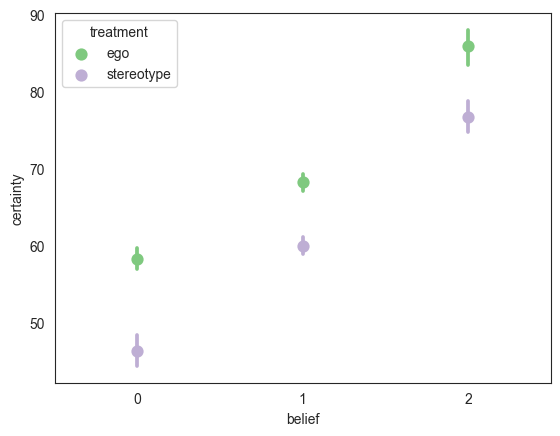

In [ ]:
sns.pointplot(data=updates, x='belief', y='certainty', join=False, hue='treatment')

<Axes: xlabel='misspecification', ylabel='certainty'>

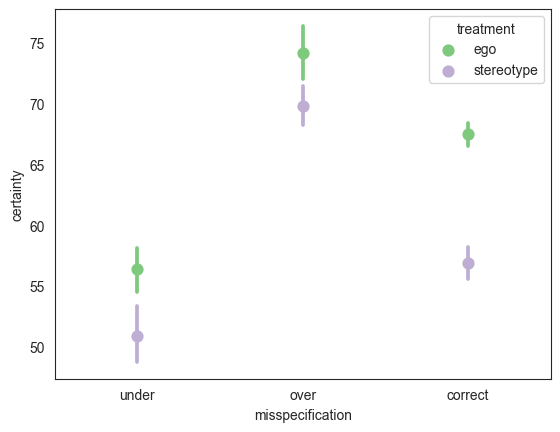

In [ ]:
# point plot of the certainty by misspecification and by treatment
sns.pointplot(data=updates, x='misspecification', y='certainty', join=False, hue='treatment')

<Axes: xlabel='topic', ylabel='certainty'>

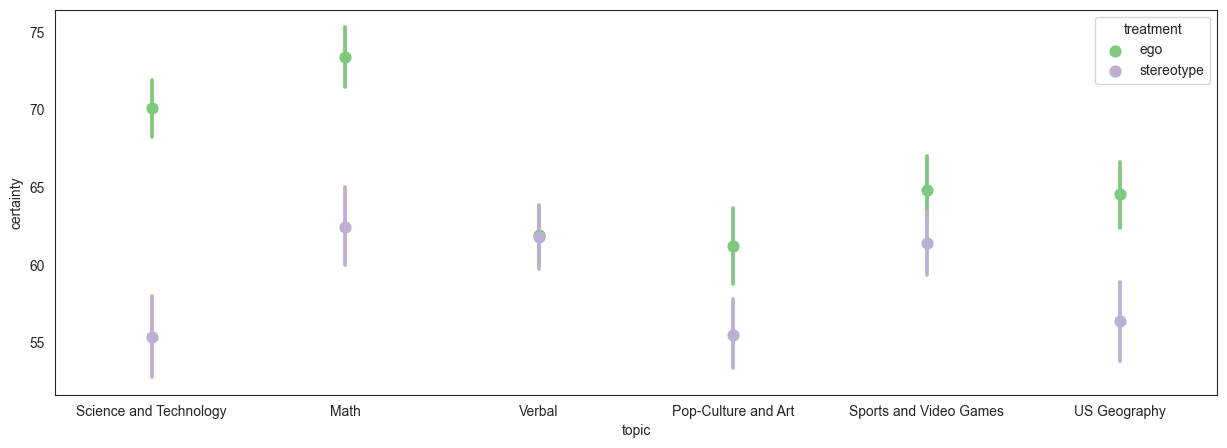

In [ ]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='certainty', join=False, hue='treatment')


<Axes: xlabel='topic', ylabel='certainty'>

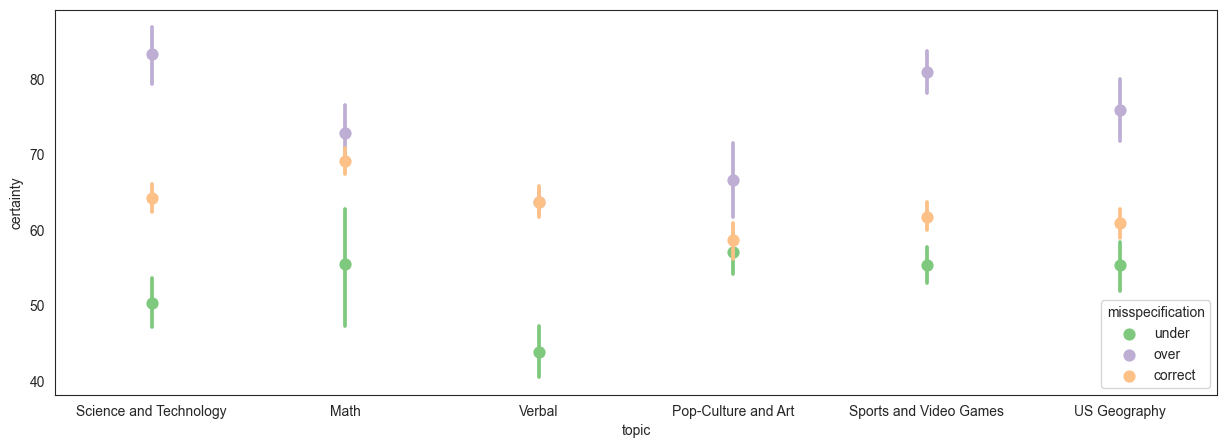

In [ ]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='certainty', join=False, hue='misspecification')

## Dogmatic v Switcher

In [ ]:
# for the cases in which we can compare between switcher and dogmatic
# get the absolute value distance to the predicted paths
dogmatic_updates['distance_switcher_abs']=np.abs(dogmatic_updates['distance_switcher'])
dogmatic_updates['distance_dogmatic_abs']=np.abs(dogmatic_updates['distance_dogmatic'])

In [ ]:
# take the average distance to the predicted path
dogmatic_updates[['distance_switcher_abs', 'distance_dogmatic_abs']].mean()

distance_switcher_abs    0.600000
distance_dogmatic_abs    0.819139
dtype: float64

In [ ]:
# test if the distances are different
stats.ttest_ind(dogmatic_updates['distance_dogmatic_abs'], dogmatic_updates['distance_switcher_abs'])

Ttest_indResult(statistic=7.761819154600344, pvalue=1.3005830702780873e-14)

In [ ]:
len(dogmatic_updates['player_code'].unique())

95

Text(0, 0.5, 'distance to model')

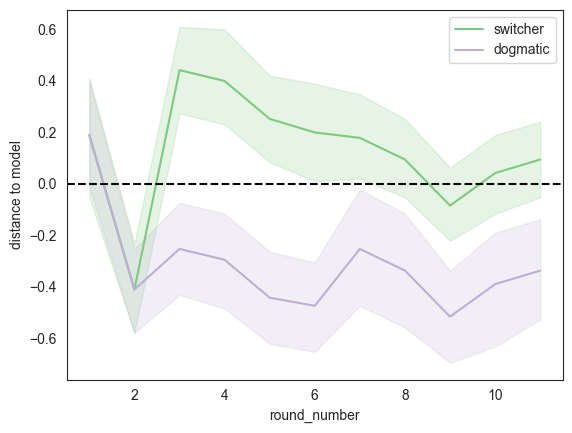

In [ ]:
# plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_switcher', label='switcher')
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic', label='dogmatic')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('distance to model')

## Byesian V Self-Serving

In [ ]:
# take the average distance to the predicted path for bayesian and self-serving
updates[['distance_bayesian_abs', 'distance_self-serving_abs']].mean()

distance_bayesian_abs        0.740028
distance_self-serving_abs    0.710468
dtype: float64

In [ ]:
# test if the distances are different
stats.ttest_ind(updates['distance_bayesian_abs'], updates['distance_self-serving_abs'])

Ttest_indResult(statistic=2.1057632280441174, pvalue=0.03525010112539511)

Text(0, 0.5, 'distance to model')

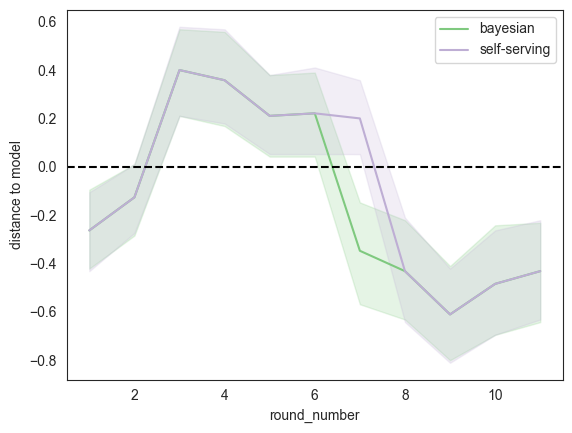

In [ ]:
 # plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_bayesian', label='bayesian')
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_self-serving', label='self-serving')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('distance to model')

# Calculate the parameters of the self-serving bias

In [ ]:
# Load the simulation from the self_serving model
sim_ss = pd.read_csv("../Simulations/demo/data/simulation_ss.csv")


In [ ]:
sim_ss = sim_ss[['round', 'effort', 'theta', 'omega', 'c_good', 'c_bad', 'prior']]
sim_ss.rename(columns={'round':'round_number', 'effort':'effort_sim', 'prior':'certainty'}, inplace=True)

In [ ]:
data = updates[['effort', 'round_number', 'certainty', 'belief', 'treatment', 'theta', 'omega', 'player_code', 'code']]

In [ ]:
sim_ss['certainty']=sim_ss['certainty']/100

In [ ]:
data_sim_ss = data.merge(sim_ss)

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_13817/3103027966.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  data_sim_ss = data.merge(sim_ss)


In [ ]:
data_sim_ss['distance'] =(data_sim_ss ['effort']-data_sim_ss['effort_sim'])**2


In [ ]:
distances_ss = data_sim_ss.groupby(['player_code', 'certainty', 'c_good', 'c_bad'])['distance'].sum().reset_index()

In [ ]:
distances_ss 

,player_code,certainty,c_good,c_bad,distance


In [ ]:
# for each player_code, find the values of c_good and c_bad that minimize the distance in distances_ss

min_distance = distances_ss.groupby('player_code').min('distance').reset_index()


In [ ]:
min_distance

,player_code,certainty,c_good,c_bad,distance


In [ ]:
c_good_est = min_distance['c_good'].mean()
c_bad_est = min_distance['c_bad'].mean()

In [ ]:
print(c_good_est)
print(c_bad_est)

nan
nan
